In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import pickle
import torch
import os
import copy
import torch.nn as nn
import seaborn as sns

# Visualize

In [2]:
import matplotlib.pyplot as plt

def plot_side_by_side(image1, image2, image3, idx, save_path, titles=None):
    """
    Plots three images side by side.

    Args:
        image1 (np.ndarray): The first image.
        image2 (np.ndarray): The second image.
        image3 (np.ndarray): The third image.
        titles (list, optional): A list of titles for the images.

    Returns:
        None
    """

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].set_title(titles[0])
    axes[0].imshow(image1)
    axes[0].axis('off')
    axes[1].set_title(titles[1])
    axes[1].imshow(image2)
    axes[1].axis('off')
    axes[2].set_title(titles[2])
    axes[2].imshow(image3)
    axes[2].axis('off')
    


    plt.tight_layout()
    
    if save_path is not None:
        filename = os.path.join(save_path, f"{idx}.jpg")
        plt.savefig(filename, bbox_inches='tight')


    plt.show()

In [3]:
def get_pred(model, images, device):
    logits = model(images.to(device))
    _, pres = logits.max(dim=1)
    return pres.cpu()

def imshow(img, title):
    img = torchvision.utils.make_grid(img.cpu().data, normalize=True)
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()


In [4]:
def lineplot_acc_perturbation(x, y, title, xlabel, ylabel, config, base_path):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x, y, label='Accuracy')
    plt.legend(loc='upper right')        
    filename = os.path.join(base_path, config + ".jpg")
    plt.savefig(filename, bbox_inches='tight')
    
def lineplot_l2radius_perturbation(x, y1, y2, title, xlabel, ylabel, config, base_path):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x, y1, label="CW Base")
    plt.plot(x, y2, label="CW + RBF")
    plt.legend(loc='upper left')
    filename = os.path.join(base_path, config + ".jpg")
    plt.savefig(filename, bbox_inches='tight')
    
    

# ResNet 

# Non-Quantized detector


In [5]:
detector = 'Regular'
c_base=0.1
d_base=0.0
c_integrated=0.2
d_integrated=0.1

base_path = f"/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f"
images_cw_base = f"Adversarial_Datasets/CW_adv_samples_5120_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}.pickle"
images_cw_rbf = f"Adversarial_Datasets/CW_adv_samples_5120_test_detector-type-{detector}_integrated-True_c-{c_integrated}_d-{d_integrated}.pickle"
images_benign = f"Benign_Datasets/CW_benign_samples_5120_test_detector-type-{detector}_integrated-True_c-{c_integrated}_d-{d_integrated}.pickle"

predictions_integrated = f"Predictions/Model/CW_type-adversarial_5120_test_detector-type-{detector}_integrated-True_c-{c_integrated}_d-{d_integrated}.pickle"
predictions_base = f"Predictions/Model/CW_type-adversarial_5120_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}.pickle"

predictions_benign_rbf = f"Predictions/RBF/CW_type-benign_5120_test_detector-type-{detector}_integrated-False_rbf_c-{c_base}_d-{d_base}.pickle"
predictions_base_rbf = f"Predictions/RBF/CW_type-adversarial_5120_test_detector-type-{detector}_integrated-False_rbf_c-{c_base}_d-{d_base}.pickle"
predictions_integrated_rbf = f"Predictions/RBF/CW_type-adversarial_5120_test_detector-type-{detector}_integrated-True_rbf_c-{c_integrated}_d-{d_integrated}.pickle"

filtered_indices_base = f"Predictions/Perturbed_Samples/CW_benign_samples_5120_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}.pt"
filtered_indices_integrated = f"Predictions/Perturbed_Samples/CW_benign_samples_5120_test_detector-type-{detector}_integrated-True_c-{c_integrated}_d-{d_integrated}.pt" 

images_cw_base = os.path.join(base_path, images_cw_base)
images_cw_rbf = os.path.join(base_path, images_cw_rbf)
images_benign = os.path.join(base_path, images_benign)
predictions_base_path = os.path.join(base_path, predictions_base)
predictions_integrated_path = os.path.join(base_path, predictions_integrated)

predictions_benign_rbf_path = os.path.join(base_path, predictions_benign_rbf)
predictions_base_rbf_path = os.path.join(base_path, predictions_base_rbf)
predictions_integrated_rbf_path = os.path.join(base_path, predictions_integrated_rbf)


filtered_indices_base_path = os.path.join(base_path, filtered_indices_base)
filtered_indices_integrated_path = os.path.join(base_path, filtered_indices_integrated)




In [6]:
# Filter by common indices
filtered_indices_base = torch.load(filtered_indices_base_path)
filtered_indices_integrated = torch.load(filtered_indices_integrated_path)


filtered_indices_base = [x.item() for x in filtered_indices_base]
filtered_indices_integrated = [x.item() for x in filtered_indices_integrated]
base_indices = set(filtered_indices_base)
integrated_indices = set(filtered_indices_integrated)
common_indices = list(base_indices.intersection(integrated_indices))


with open(images_cw_base, 'rb') as in_file:
    images_cw_base = pickle.load(in_file)
    images_cw_base[0] = images_cw_base[0][common_indices]
    images_cw_base[1] = images_cw_base[1][common_indices]
    

with open(images_cw_rbf, 'rb') as in_file:
    images_cw_rbf = pickle.load(in_file)
    images_cw_rbf[0] = images_cw_rbf[0][common_indices]
    images_cw_rbf[1] = images_cw_rbf[1][common_indices]


with open(images_benign, 'rb') as in_file:
    images_benign = pickle.load(in_file)
    images_benign[0] = images_benign[0][common_indices]
    images_benign[1] = images_benign[1][common_indices]




with open(predictions_base_path, 'rb') as in_file:
    predictions = pickle.load(in_file)
    true_labels_base = np.asarray(predictions['true_labels'])[common_indices]
    pred_labels_base = np.asarray(predictions['pred_labels'])[common_indices]

with open(predictions_integrated_path, 'rb') as in_file:
    predictions = pickle.load(in_file)
    true_labels_integrated = np.asarray(predictions['true_labels'])[common_indices]
    pred_labels_integrated = np.asarray(predictions['pred_labels'])[common_indices]


with open(predictions_benign_rbf_path, 'rb') as in_file:
    predictions = pickle.load(in_file)
    true_labels_benign_rbf = np.asarray(predictions['true_labels'])[common_indices]
    pred_labels_benign_rbf = np.asarray(predictions['pred_labels'])[common_indices]
    pred_scores_benign_rbf = np.asarray(predictions['pred_scores'])[common_indices]

with open(predictions_base_rbf_path, 'rb') as in_file:
    predictions = pickle.load(in_file)
    true_labels_base_rbf = np.asarray(predictions['true_labels'])[common_indices]
    pred_labels_base_rbf = np.asarray(predictions['pred_labels'])[common_indices]
    pred_scores_base_rbf = np.asarray(predictions['pred_scores'])[common_indices]

with open(predictions_integrated_rbf_path, 'rb') as in_file:
    predictions = pickle.load(in_file)
    true_labels_integrated_rbf = np.asarray(predictions['true_labels'])[common_indices]
    pred_labels_integrated_rbf = np.asarray(predictions['pred_labels'])[common_indices]
    pred_scores_integrated_rbf = np.asarray(predictions['pred_scores'])[common_indices]




In [7]:
# Get distribution plots for all 3

benign_rbf_indices = np.where(pred_scores_benign_rbf > 0)[0]
base_rbf_indices = np.where(pred_scores_base_rbf > 0)[0]
integrated_rbf_indices = np.where(pred_scores_integrated_rbf > 0)[0]

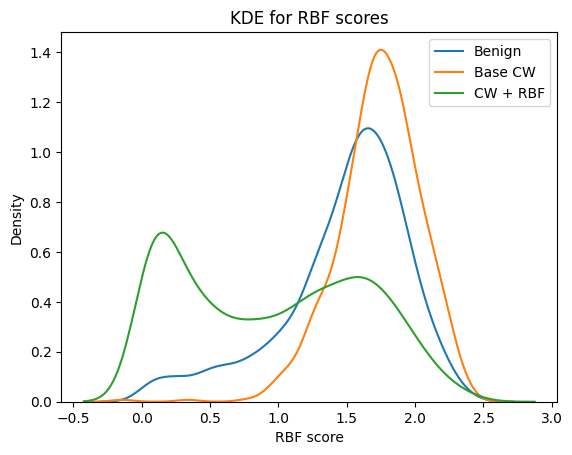

In [12]:
sns.kdeplot(pred_scores_benign_rbf[benign_rbf_indices])
sns.kdeplot(pred_scores_benign_rbf[base_rbf_indices])
sns.kdeplot(pred_scores_integrated_rbf[integrated_rbf_indices])
plt.legend(labels=['Benign', "Base CW", "CW + RBF"])
plt.title("KDE for RBF scores")
plt.xlabel("RBF score")
config = f"KDE_{detector}_c_base-{c_base}_d-base-{d_base}_c_integrated-{c_integrated}_d_integrated-{d_integrated}.png"
path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f/Plots"
filename = os.path.join(path, config)
plt.savefig(filename, bbox_inches='tight')



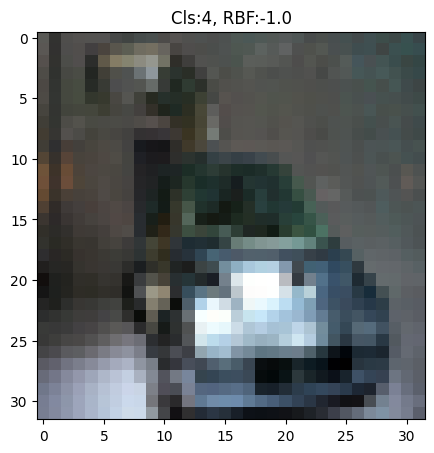

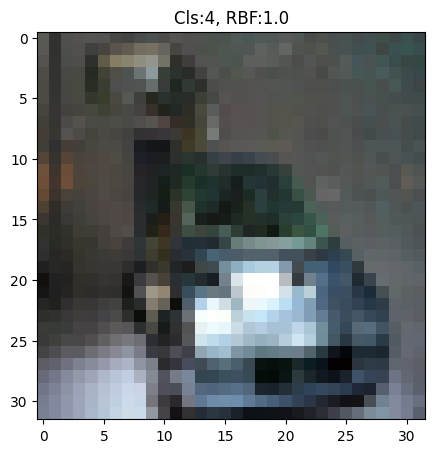

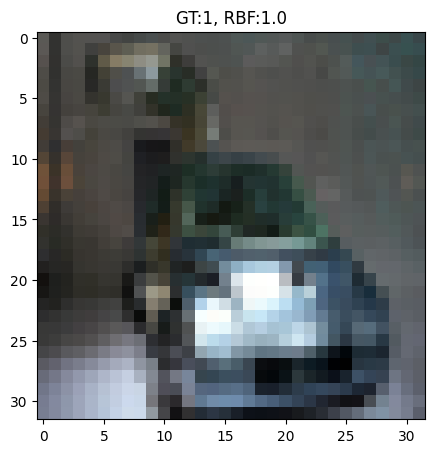

In [10]:
idx = 78
title = f'Cls:{pred_labels_base[idx]}, RBF:{pred_labels_base_rbf[idx]}'
imshow(images_cw_base[0][idx], title=title)
title = f'Cls:{pred_labels_integrated[idx]}, RBF:{pred_labels_integrated_rbf[idx]}'
imshow(images_cw_rbf[0][idx], title=title)
title = f'GT:{true_labels_base[idx]}, RBF:{pred_labels_benign_rbf[idx]}'
imshow(images_benign[0][idx], title=title)

# Compute pixel-wise metrics


In [11]:
MSELoss_none = nn.MSELoss(reduction='none')
MSELoss = nn.MSELoss(reduction='mean')
flatten = nn.Flatten()

In [12]:
l2_loss_base_per_sample = MSELoss_none(flatten(images_cw_base[0]), flatten(images_benign[0]))
l2_loss_base_per_sample = l2_loss_base_per_sample.sum(dim=1).mean()

l2_loss_integrated_per_sample = MSELoss_none(flatten(images_cw_rbf[0]), flatten(images_benign[0]))
l2_loss_integrated_per_sample = l2_loss_integrated_per_sample.sum(dim=1).mean()
print(f"L2 Ball : Base {l2_loss_base_per_sample}, Integrated : {l2_loss_integrated_per_sample}")

L2 Ball : Base 0.03400504216551781, Integrated : 0.07558941841125488


In [13]:
l2_loss_base = MSELoss(flatten(images_cw_base[0]), flatten(images_benign[0]))
l2_loss_rbf = MSELoss(flatten(images_cw_rbf[0]), flatten(images_benign[0]))
print(f"Mean Per pixel : Base {l2_loss_base}, Integrated : {l2_loss_rbf}")

Mean Per pixel : Base 1.1069349966419395e-05, Integrated : 2.4605928047094494e-05


In [14]:
l2_loss_base = MSELoss_none(flatten(images_cw_base[0]), flatten(images_benign[0]))
l2_loss_base = torch.max(l2_loss_base, dim=1)[0]
l2_loss_base = l2_loss_base.mean().item()

l2_loss_rbf = MSELoss_none(flatten(images_cw_rbf[0]), flatten(images_benign[0]))
l2_loss_rbf = torch.max(l2_loss_rbf, dim=1)[0]
l2_loss_rbf = l2_loss_rbf.mean().item()
#print("Mean max pixel differene between CW RBF and benign is : ", l2_loss_rbf.item())
#print("Mean max pixel differene between CW base and benign is : ", l2_loss_base.item())
print(f"Max pixel : Base {l2_loss_base}, Integrated : {l2_loss_rbf}")

Max pixel : Base 0.00045511533971875906, Integrated : 0.0009169624536298215


# Plots

### Accuracy vs Perturbation C

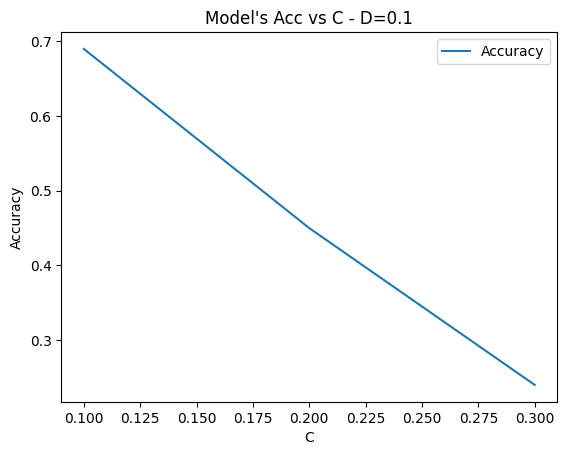

In [5]:
# Accuracy vs Perturbation C
d=0.1
type='Regular'
acc = [0.69,0.45,0.24]
c = [0.1, 0.2, 0.3]
title=f"Model's Acc vs C - D={d}"
xlabel = "C"
ylabel = "Accuracy"
base_path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f/Plots"
config=f"acc_vs_pertur_d-{d}_type-{type}"

lineplot_acc_perturbation(c, acc,title, xlabel, ylabel, config, base_path)


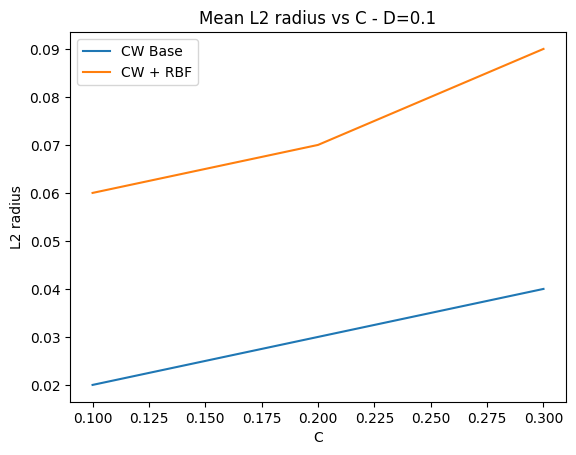

In [15]:

# Accuracy vs Perturbation C
d=0.1
type='Regular'
base_l2 = [0.02,0.03,0.04]
integrated_l2 =[0.06,0.07,0.09]

c = [0.1, 0.2, 0.3]
title=f"Mean L2 radius vs C - D={d}"
xlabel = "C"
ylabel = "L2 radius"
base_path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f/Plots"
config=f"l2radius_vs_pertur_d-{d}_type-{type}"

lineplot_l2radius_perturbation(c,base_l2, integrated_l2, title, xlabel, ylabel, config, base_path)


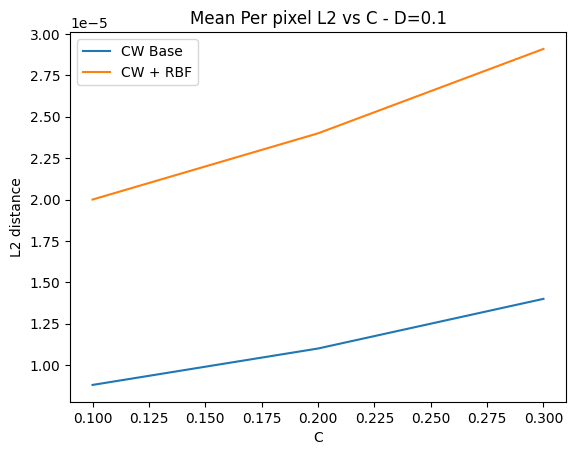

In [7]:
# Accuracy vs Perturbation C
d=0.1
type='Regular'
base_l2 = [8.8e-06,1.1e-05,1.4e-05]
integrated_l2 =[2.e-05,2.4e-05,2.91e-05]
c = [0.1, 0.2, 0.3]
title=f"Mean Per pixel L2 vs C - D={d}"
xlabel = "C"
ylabel = "L2 distance"
base_path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f/Plots"
config=f"l2distance_vs_pertur_d-{d}_type-{type}"

lineplot_l2radius_perturbation(c,base_l2, integrated_l2, title, xlabel, ylabel, config, base_path)


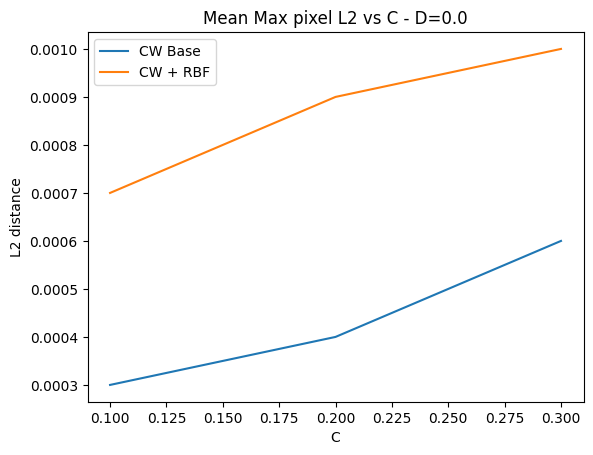

In [8]:
# Accuracy vs Perturbation C
d=0.0
type='Regular'
base_l2 = [0.0003,0.0004,0.0006]
integrated_l2 =[0.0007,0.0009,0.001]

c = [0.1, 0.2, 0.3]
title=f"Mean Max pixel L2 vs C - D={d}"
xlabel = "C"
ylabel = "L2 distance"
base_path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f/Plots"
config=f"maxl2distance_vs_pertur_d-{d}_type-{type}"

lineplot_l2radius_perturbation(c,base_l2, integrated_l2, title, xlabel, ylabel, config, base_path)


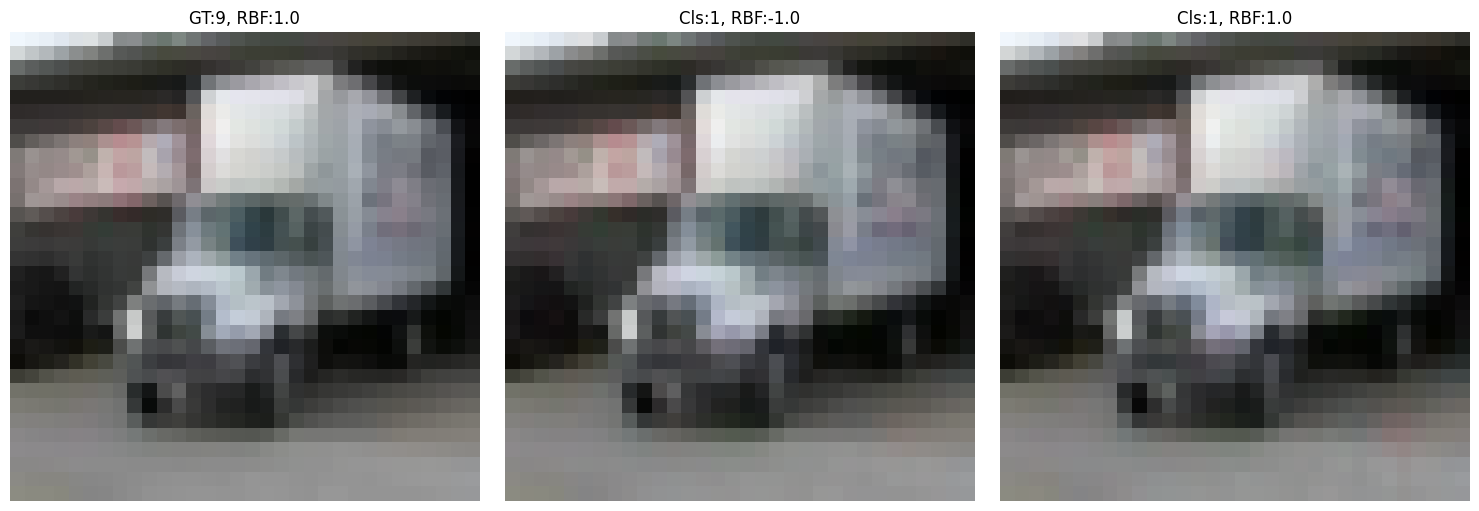

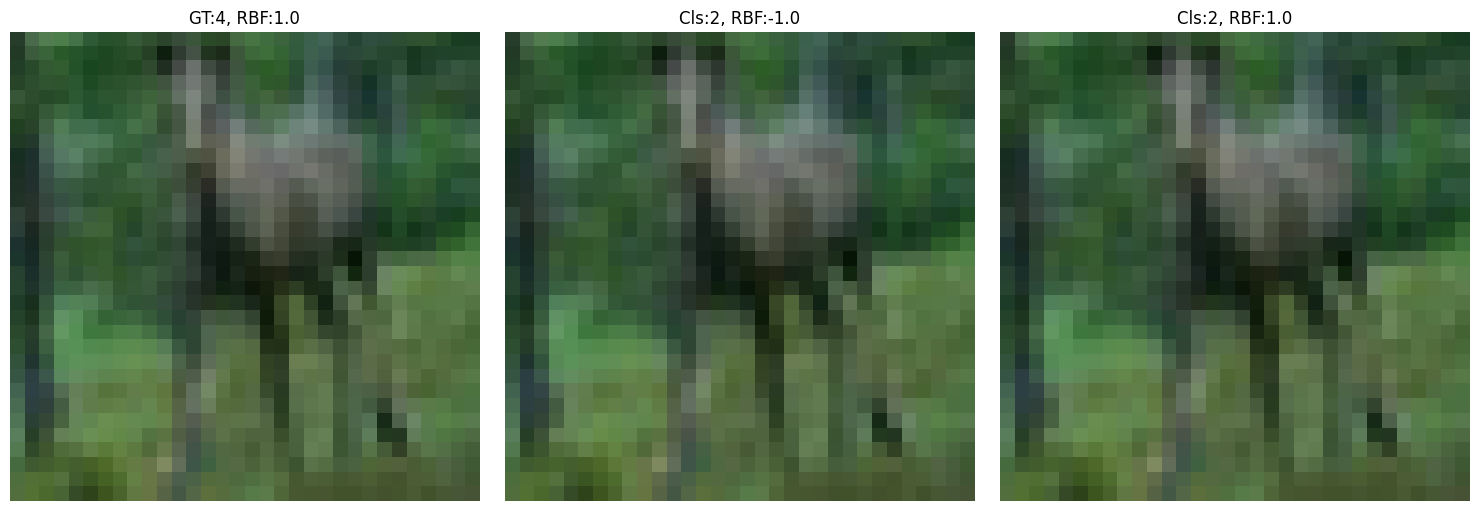

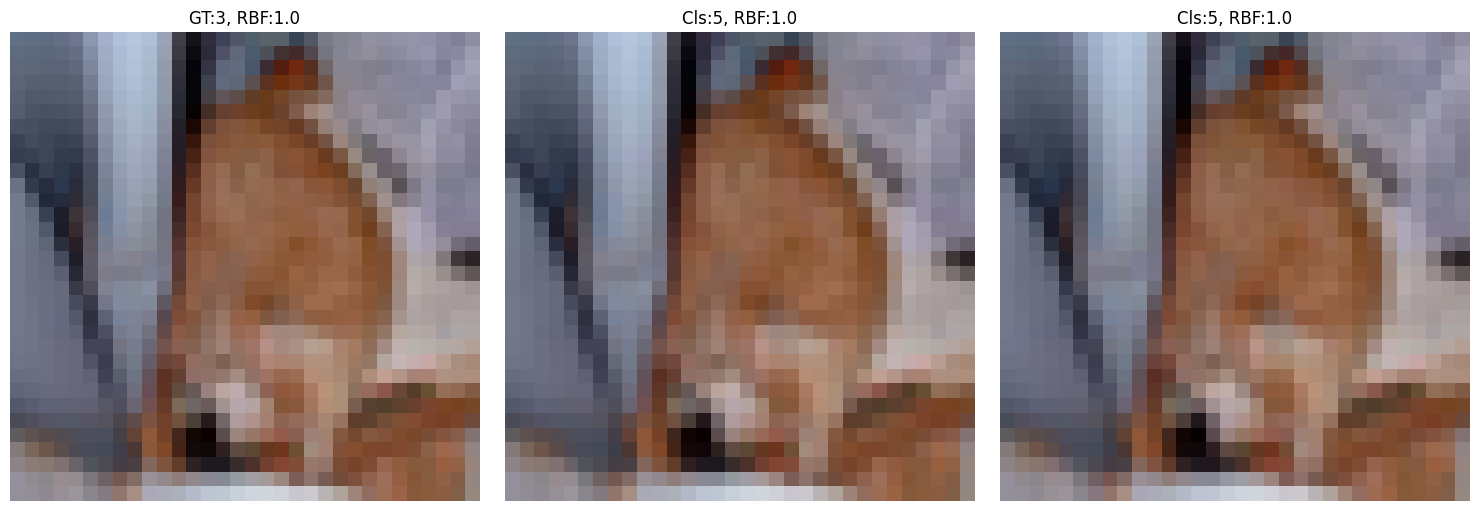

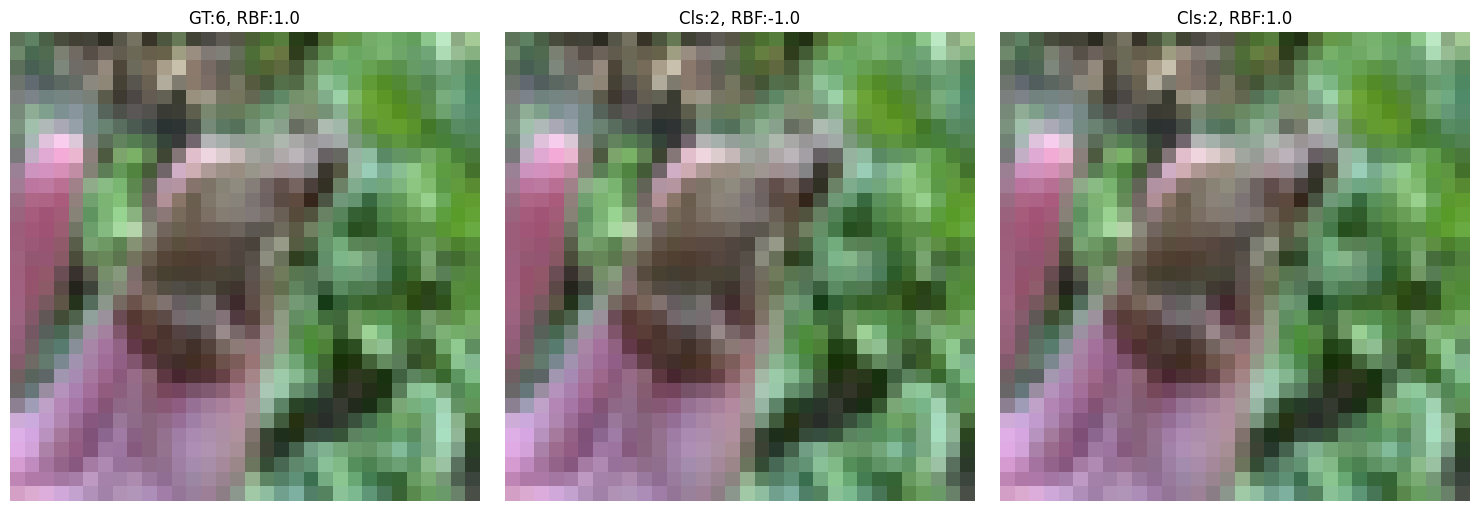

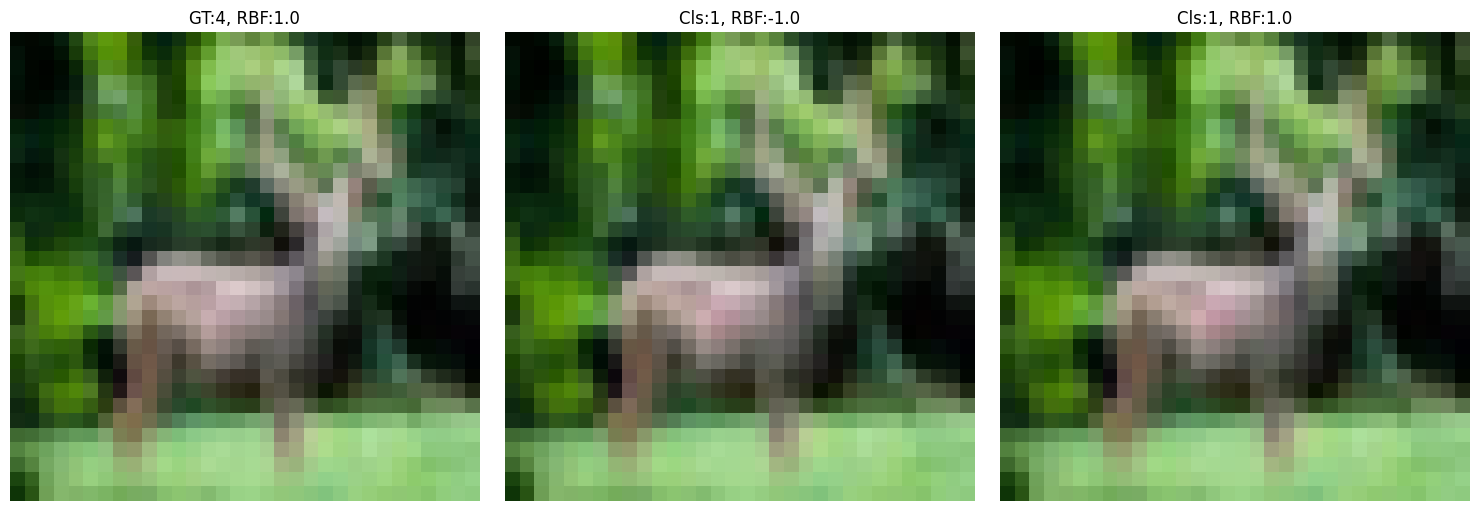

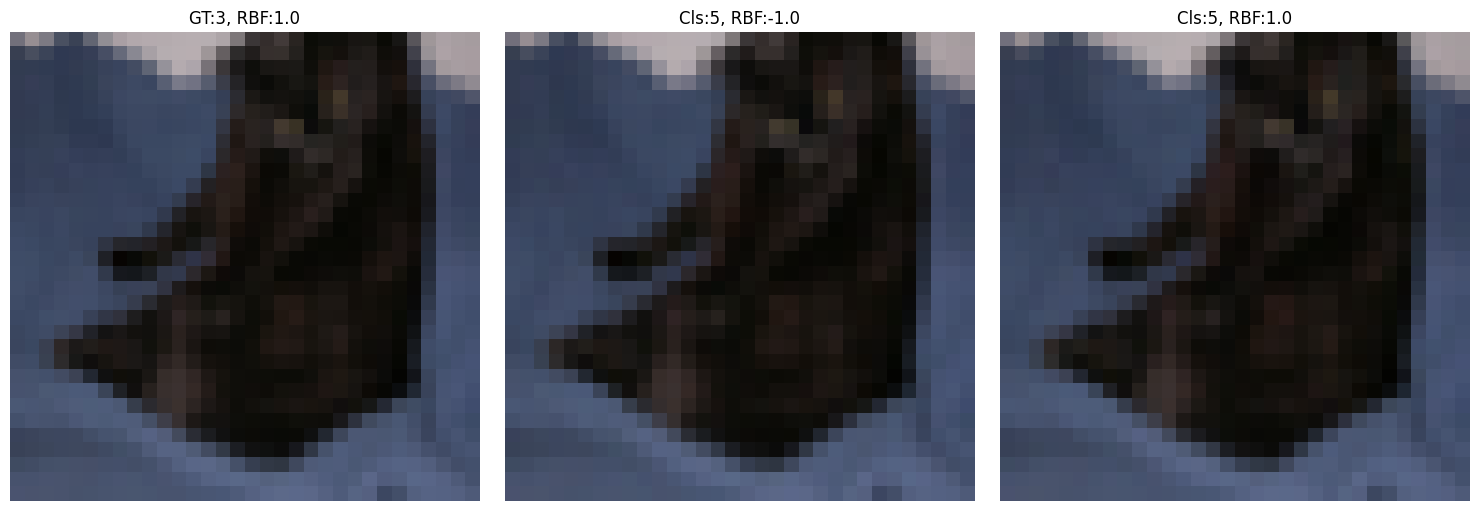

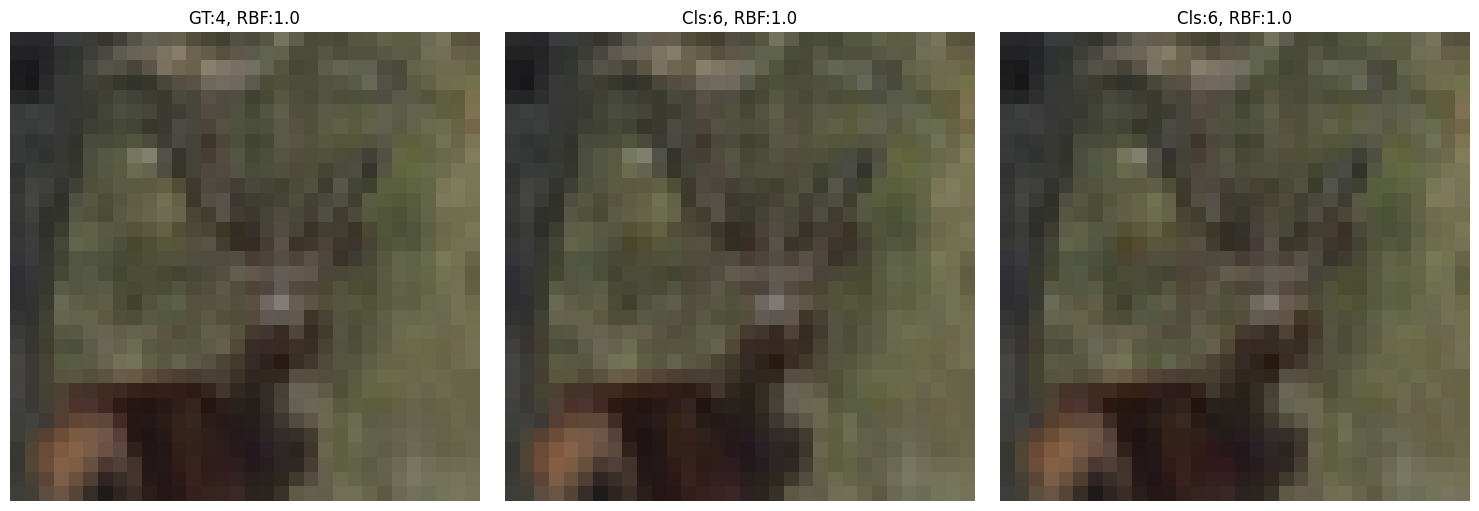

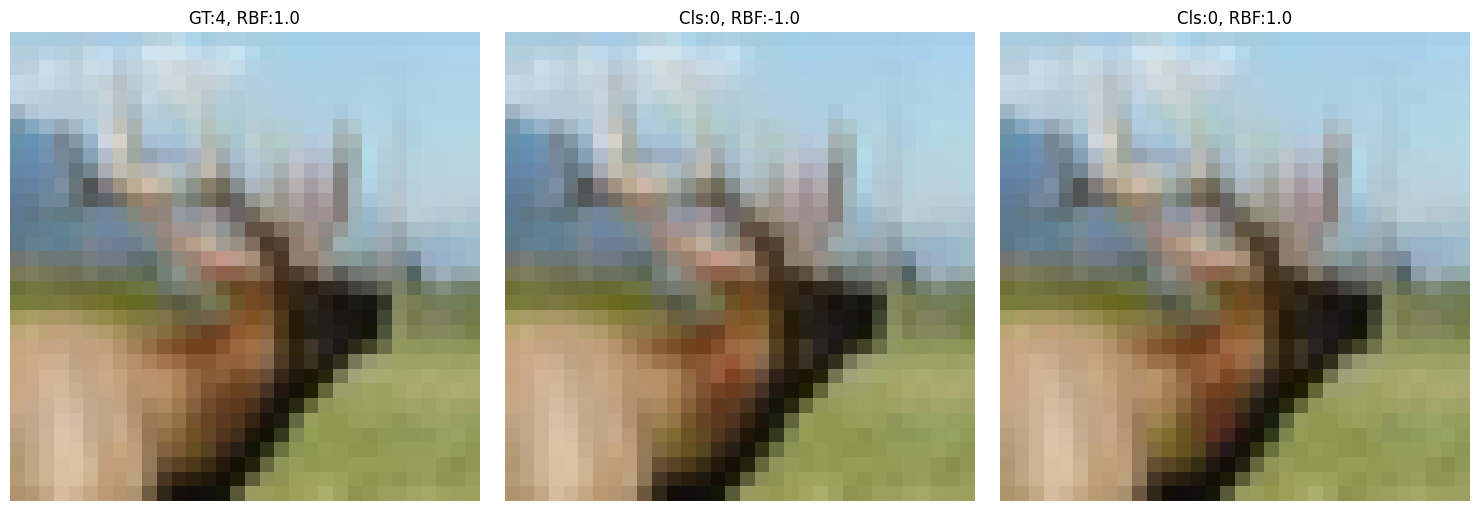

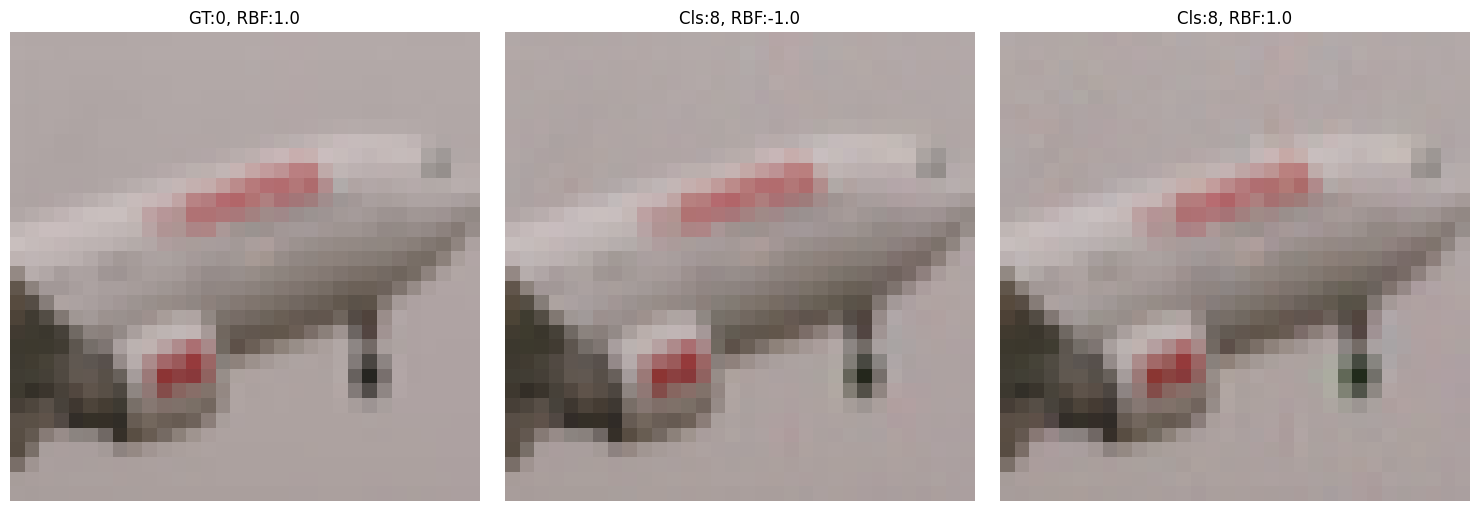

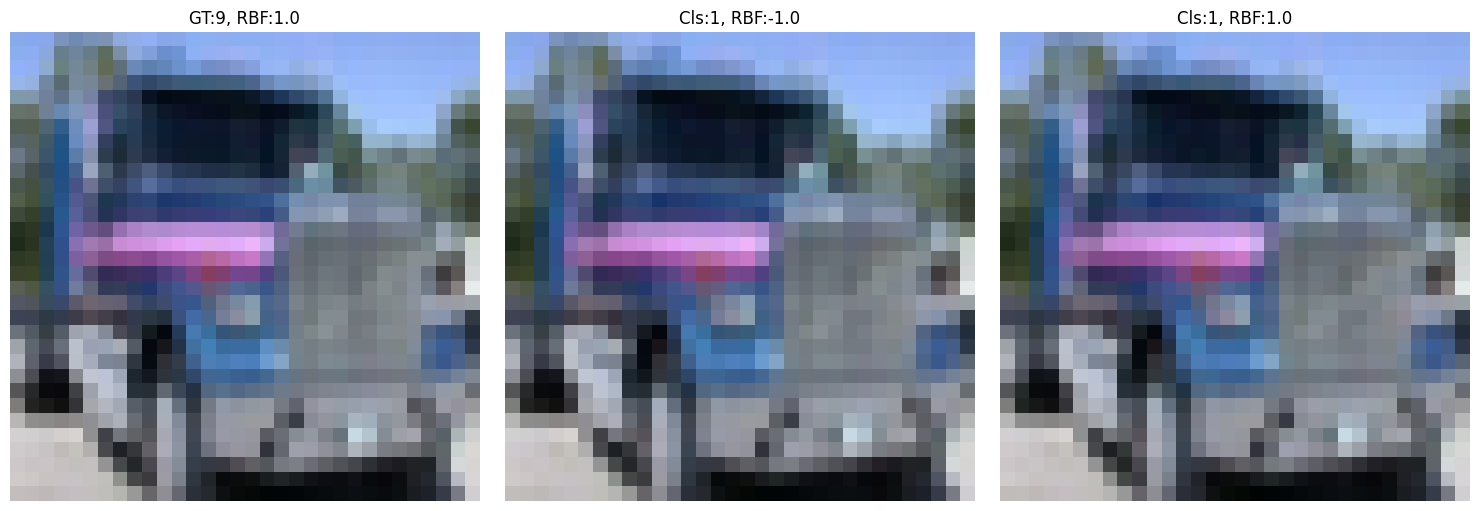

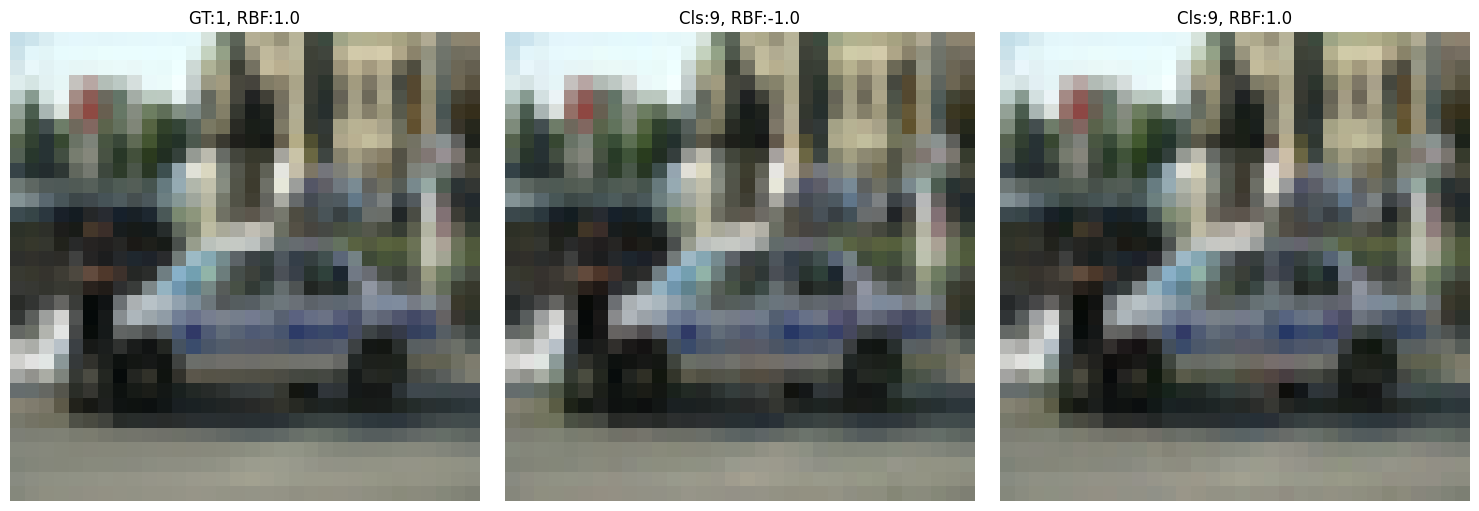

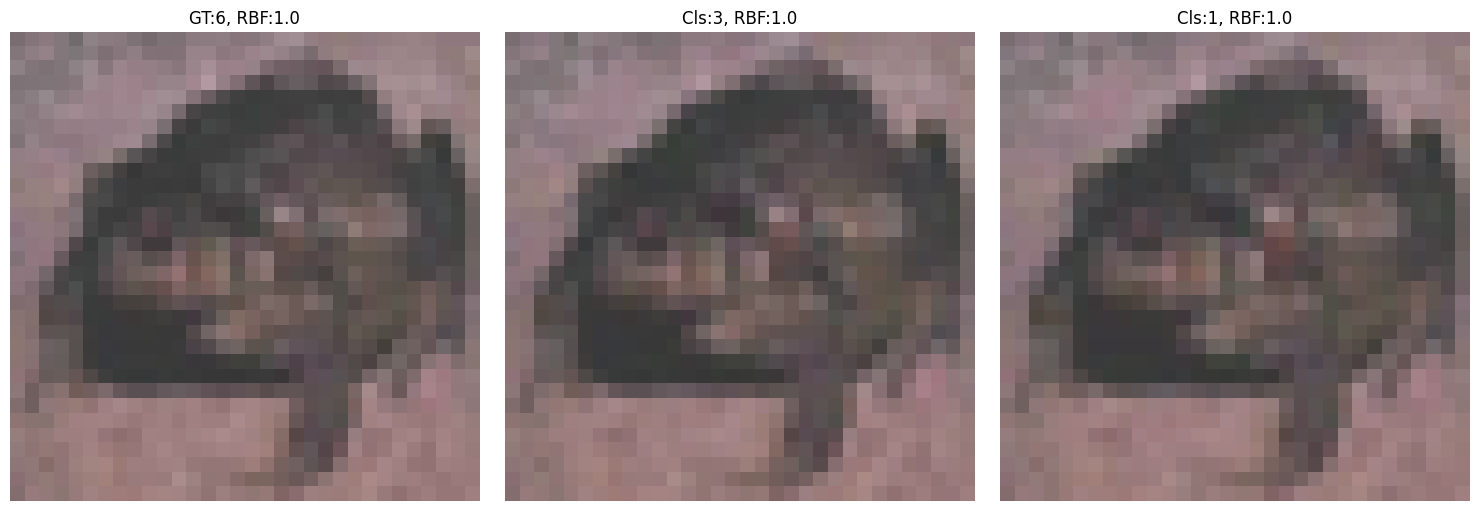

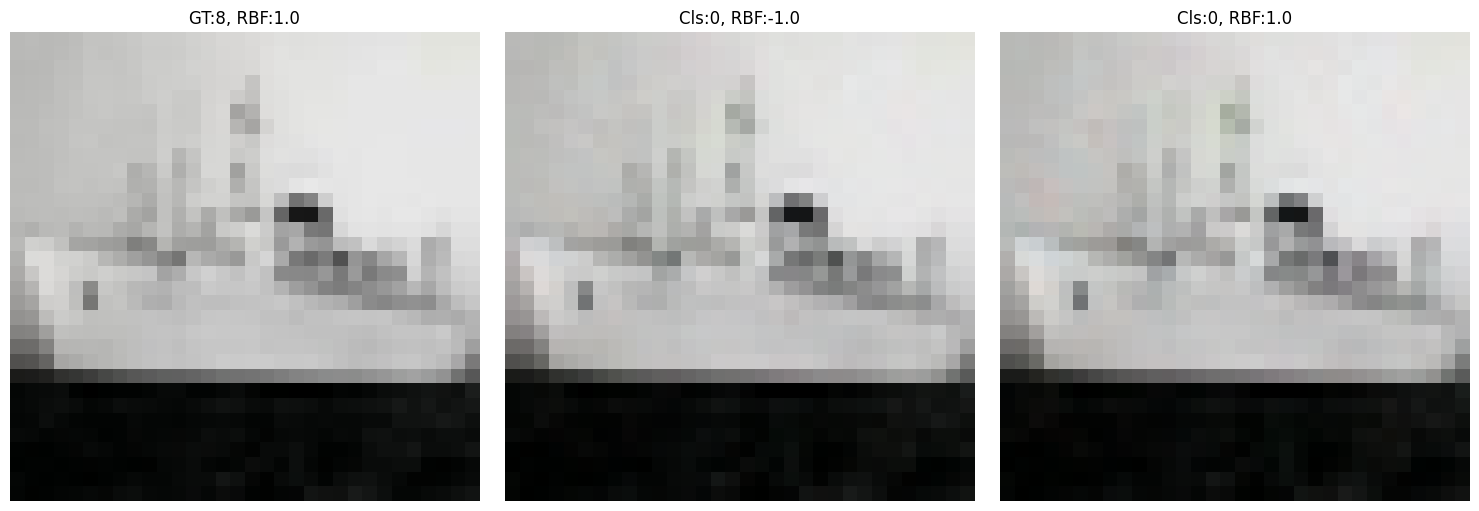

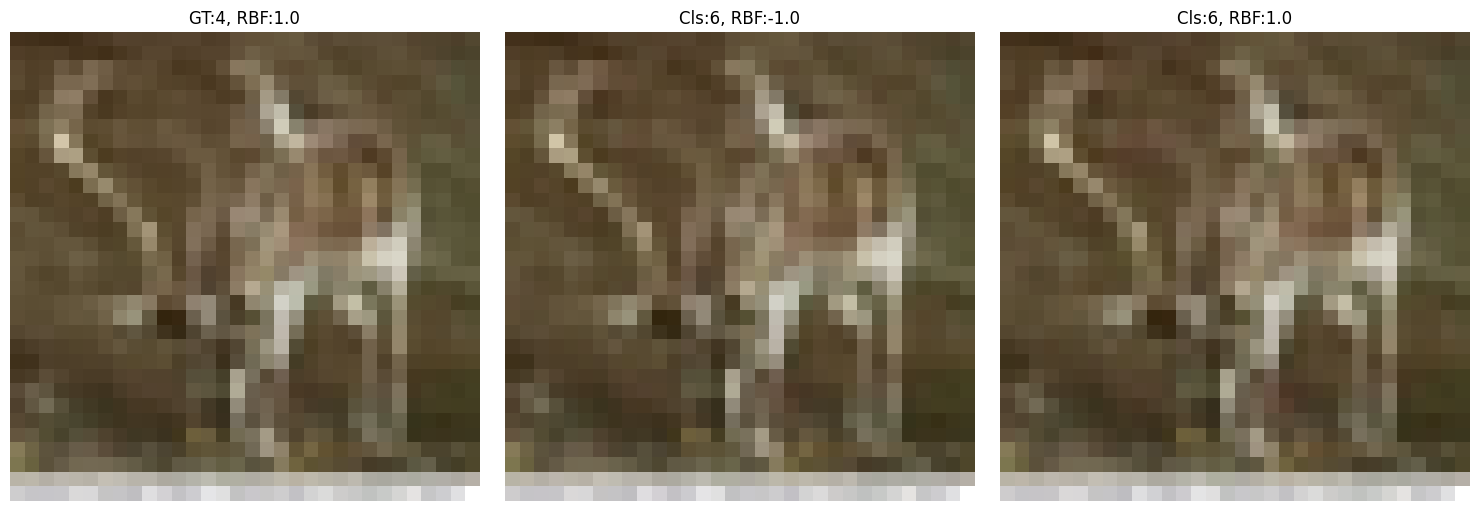

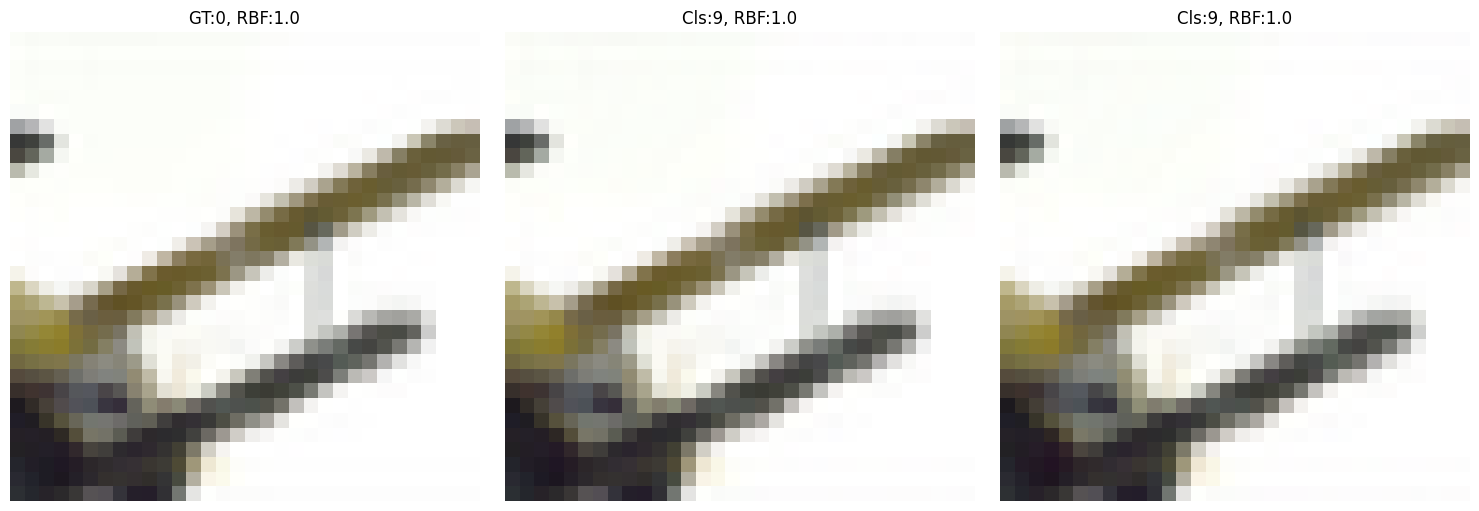

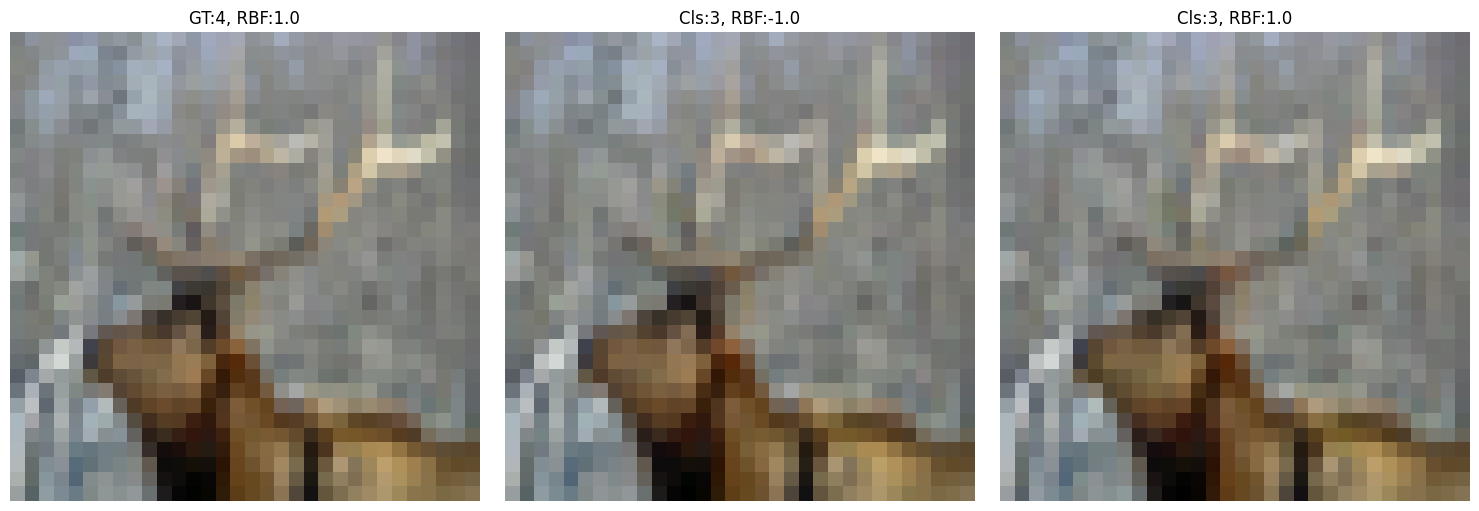

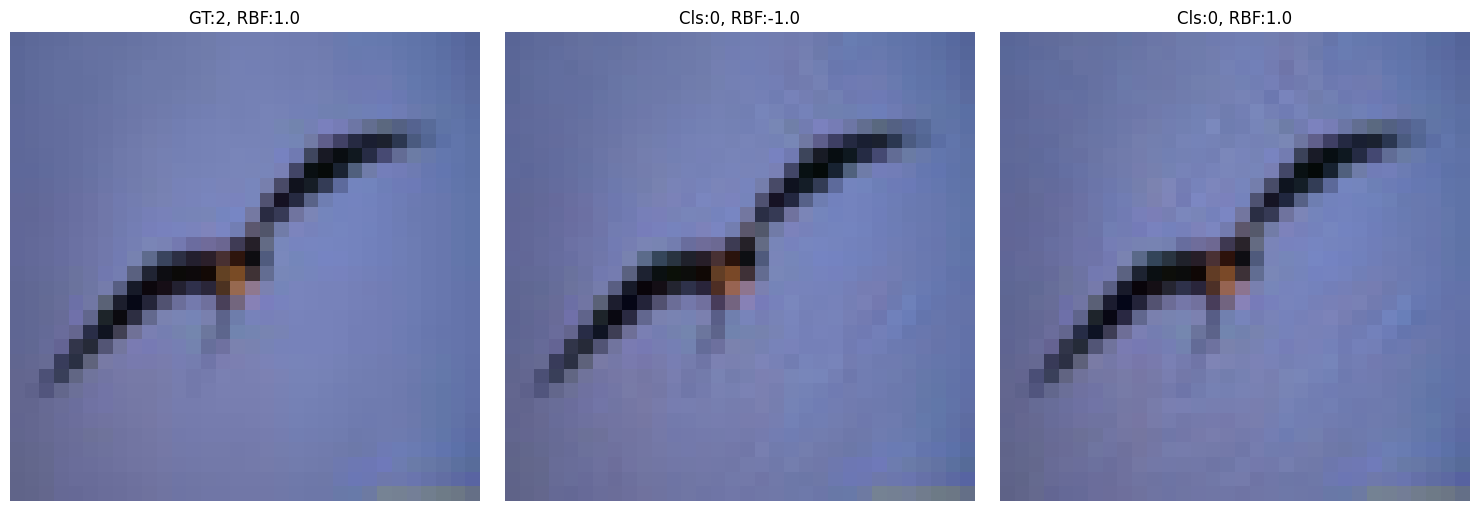

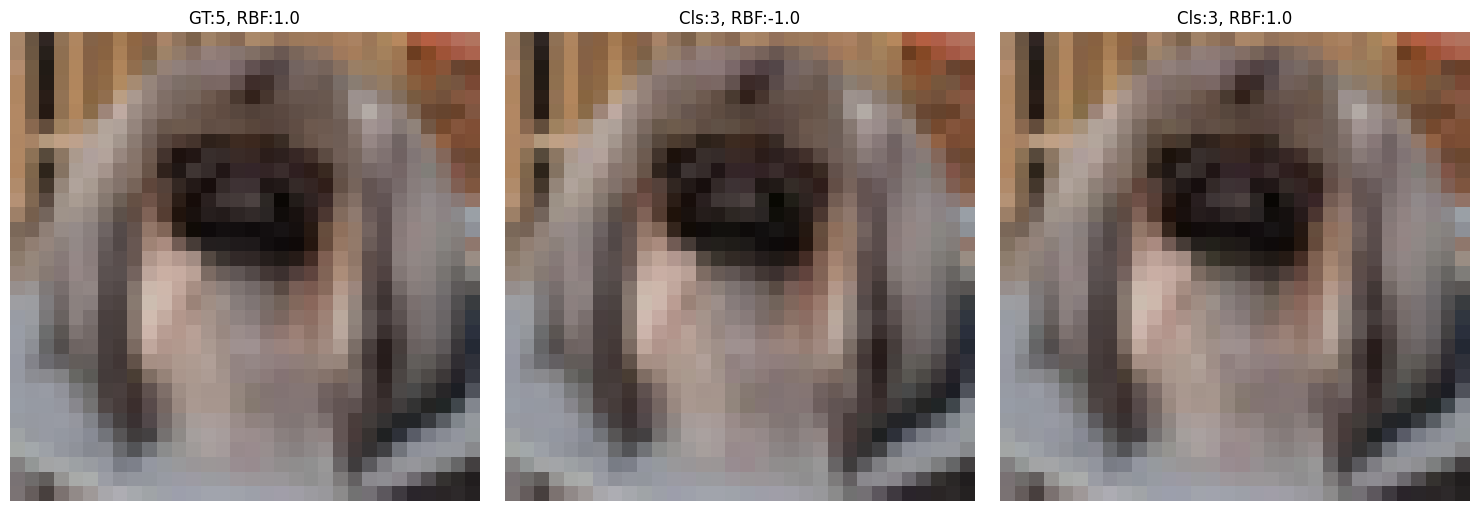

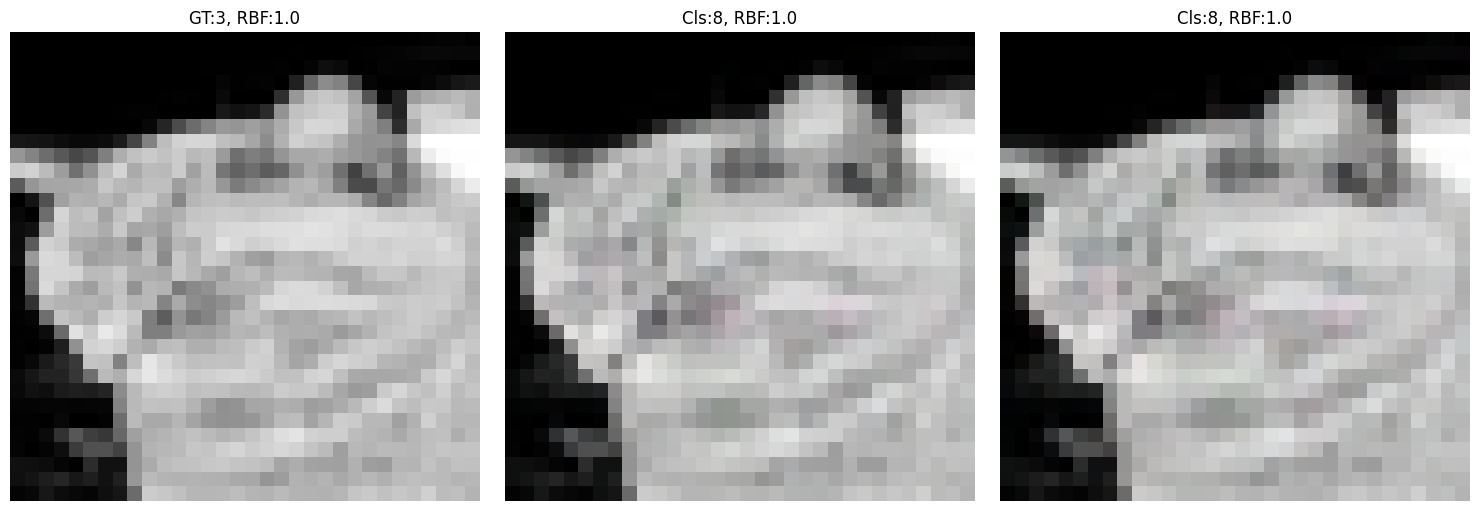

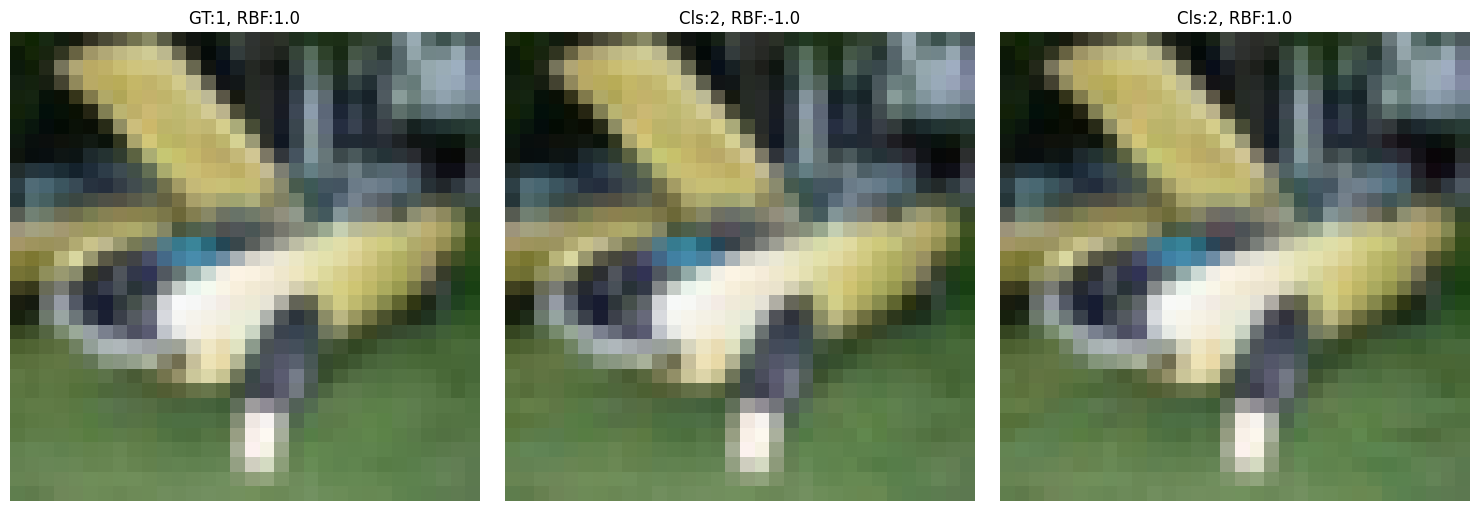

In [30]:
save_path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f/Vis"

for idx in range(20):
    benign = images_benign[0][idx]
    cw_base = images_cw_base[0][idx]
    cw_rbf = images_cw_rbf[0][idx]

    benign = benign.swapaxes(0,1)
    benign = benign.swapaxes(1,2)

    cw_base = cw_base.swapaxes(0,1)
    cw_base = cw_base.swapaxes(1,2)

    cw_rbf = cw_rbf.swapaxes(0,1)
    cw_rbf = cw_rbf.swapaxes(1,2)

    title_benign = f'GT:{true_labels_base[idx]}, RBF:{pred_labels_benign_rbf[idx]}'
    title_base = f'Cls:{pred_labels_base[idx]}, RBF:{pred_labels_base_rbf[idx]}'
    title_integrated = f'Cls:{pred_labels_integrated[idx]}, RBF:{pred_labels_integrated_rbf[idx]}'
    titles = [title_benign, title_base, title_integrated]
    plot_side_by_side(benign, cw_base, cw_rbf, idx, save_path, titles=titles)

# Quantized detector

In [6]:
detector = 'Quantized'
c_base=0.1
d_base=0.0
c_integrated=0.1
d_integrated=0.1

base_path = f"/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f"
images_cw_base = f"Adversarial_Datasets/CW_adv_samples_5120_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}.pickle"
images_cw_rbf = f"Adversarial_Datasets/CW_adv_samples_5120_test_detector-type-{detector}_integrated-True_c-{c_integrated}_d-{d_integrated}.pickle"
images_benign = f"Benign_Datasets/CW_benign_samples_5120_test_detector-type-{detector}_integrated-True_c-{c_integrated}_d-{d_integrated}.pickle"

predictions_integrated = f"Predictions/Model/CW_type-adversarial_5120_test_detector-type-{detector}_integrated-True_c-{c_integrated}_d-{d_integrated}.pickle"
predictions_base = f"Predictions/Model/CW_type-adversarial_5120_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}.pickle"

predictions_benign_rbf = f"Predictions/RBF/CW_type-benign_5120_test_detector-type-{detector}_integrated-False_rbf_c-{c_base}_d-{d_base}.pickle"
predictions_base_rbf = f"Predictions/RBF/CW_type-adversarial_5120_test_detector-type-{detector}_integrated-False_rbf_c-{c_base}_d-{d_base}.pickle"
predictions_integrated_rbf = f"Predictions/RBF/CW_type-adversarial_5120_test_detector-type-{detector}_integrated-True_rbf_c-{c_integrated}_d-{d_integrated}.pickle"

filtered_indices_base = f"Predictions/Perturbed_Samples/CW_benign_samples_5120_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}.pt"
filtered_indices_integrated = f"Predictions/Perturbed_Samples/CW_benign_samples_5120_test_detector-type-{detector}_integrated-True_c-{c_integrated}_d-{d_integrated}.pt" 

images_cw_base = os.path.join(base_path, images_cw_base)
images_cw_rbf = os.path.join(base_path, images_cw_rbf)
images_benign = os.path.join(base_path, images_benign)
predictions_base_path = os.path.join(base_path, predictions_base)
predictions_integrated_path = os.path.join(base_path, predictions_integrated)

predictions_benign_rbf_path = os.path.join(base_path, predictions_benign_rbf)
predictions_base_rbf_path = os.path.join(base_path, predictions_base_rbf)
predictions_integrated_rbf_path = os.path.join(base_path, predictions_integrated_rbf)


filtered_indices_base_path = os.path.join(base_path, filtered_indices_base)
filtered_indices_integrated_path = os.path.join(base_path, filtered_indices_integrated)




In [7]:
# Filter by common indices
filtered_indices_base = torch.load(filtered_indices_base_path)
filtered_indices_integrated = torch.load(filtered_indices_integrated_path)


filtered_indices_base = [x.item() for x in filtered_indices_base]
filtered_indices_integrated = [x.item() for x in filtered_indices_integrated]
base_indices = set(filtered_indices_base)
integrated_indices = set(filtered_indices_integrated)
common_indices = list(base_indices.intersection(integrated_indices))


with open(images_cw_base, 'rb') as in_file:
    images_cw_base = pickle.load(in_file)
    images_cw_base[0] = images_cw_base[0][common_indices]
    images_cw_base[1] = images_cw_base[1][common_indices]
    

with open(images_cw_rbf, 'rb') as in_file:
    images_cw_rbf = pickle.load(in_file)
    images_cw_rbf[0] = images_cw_rbf[0][common_indices]
    images_cw_rbf[1] = images_cw_rbf[1][common_indices]


with open(images_benign, 'rb') as in_file:
    images_benign = pickle.load(in_file)
    images_benign[0] = images_benign[0][common_indices]
    images_benign[1] = images_benign[1][common_indices]

with open(predictions_base_path, 'rb') as in_file:
    predictions = pickle.load(in_file)
    true_labels_base = np.asarray(predictions['true_labels'])[common_indices]
    pred_labels_base = np.asarray(predictions['pred_labels'])[common_indices]

with open(predictions_integrated_path, 'rb') as in_file:
    predictions = pickle.load(in_file)
    true_labels_integrated = np.asarray(predictions['true_labels'])[common_indices]
    pred_labels_integrated = np.asarray(predictions['pred_labels'])[common_indices]

with open(predictions_benign_rbf_path, 'rb') as in_file:
    predictions = pickle.load(in_file)
    true_labels_benign_rbf = np.asarray(predictions['true_labels'])[common_indices]
    pred_labels_benign_rbf = np.asarray(predictions['pred_labels'])[common_indices]
    pred_scores_benign_rbf = np.asarray(predictions['pred_scores'])[common_indices]
    pred_thresholded_scores_benign_rbf = np.asarray(predictions['pred_scores_thresholded'])[common_indices]

with open(predictions_base_rbf_path, 'rb') as in_file:
    predictions = pickle.load(in_file)
    true_labels_base_rbf = np.asarray(predictions['true_labels'])[common_indices]
    pred_labels_base_rbf = np.asarray(predictions['pred_labels'])[common_indices]
    pred_scores_base_rbf = np.asarray(predictions['pred_scores'])[common_indices]
    pred_thresholded_scores_base_rbf =  np.asarray(predictions['pred_scores_thresholded'])[common_indices]

with open(predictions_integrated_rbf_path, 'rb') as in_file:
    predictions = pickle.load(in_file)
    true_labels_integrated_rbf = np.asarray(predictions['true_labels'])[common_indices]
    pred_labels_integrated_rbf = np.asarray(predictions['pred_labels'])[common_indices]
    pred_scores_integrated_rbf = np.asarray(predictions['pred_scores'])[common_indices]
    pred_thresholded_scores_integrated_rbf = np.asarray(predictions['pred_scores_thresholded'])[common_indices]





'/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f/Plots/KDE_Quantized_c_base-0.1_d-base-0.0_c_integrated-0.1_d_integrated-0.1.png'

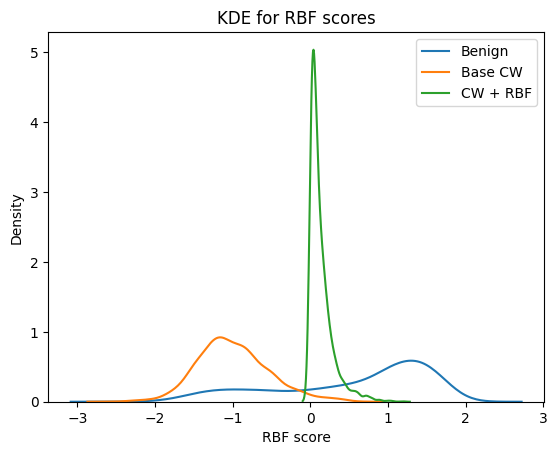

In [8]:
# Get distribution plots for all 3

benign_rbf_indices = np.where(pred_scores_benign_rbf > 0)[0]
base_rbf_indices = np.where(pred_scores_base_rbf > 0)[0]
integrated_rbf_indices = np.where(pred_scores_integrated_rbf > 0)[0]

# Save plot

#sns.kdeplot(pred_scores_benign_rbf[benign_rbf_indices])
#sns.kdeplot(pred_scores_base_rbf[base_rbf_indices])
#sns.kdeplot(pred_scores_integrated_rbf[integrated_rbf_indices])


sns.kdeplot(pred_scores_benign_rbf)
sns.kdeplot(pred_scores_base_rbf)
sns.kdeplot(pred_scores_integrated_rbf)



plt.legend(labels=['Benign', "Base CW", "CW + RBF"])
plt.title("KDE for RBF scores")
plt.xlabel("RBF score")
config = f"KDE_{detector}_c_base-{c_base}_d-base-{d_base}_c_integrated-{c_integrated}_d_integrated-{d_integrated}.png"
path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f/Plots"
filename = os.path.join(path, config)
plt.savefig(filename, bbox_inches='tight')
filename


'/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f/Plots/RBF-Thresholds_Quantized_c_base-0.1_d-base-0.0_c_integrated-0.1_d_integrated-0.1.png'

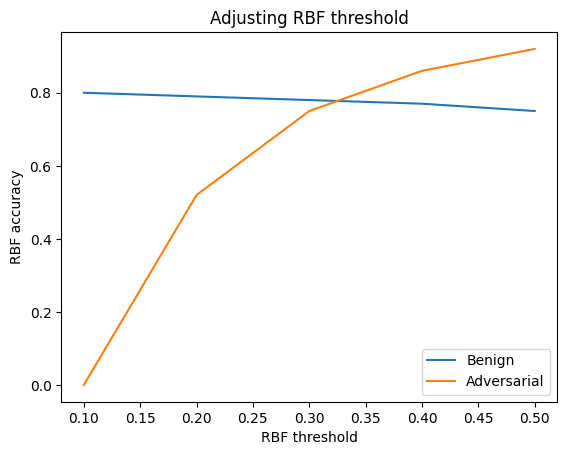

In [23]:
# Plot for RBF threshold adjustment
benign_acc_rbf = [0.8, 0.79, 0.78, 0.77, 0.75 ]
adv_acc_rbf = [0, 0.52, 0.75, 0.86,0.92]
rbf_threshold = [0.1, 0.2, 0.3, 0.4, 0.5]

plt.plot(rbf_threshold, benign_acc_rbf,label="Benign")
plt.plot(rbf_threshold, adv_acc_rbf, label='Adversarial')
plt.legend(loc='lower right')
plt.xlabel("RBF threshold")
plt.ylabel("RBF accuracy")
plt.title("Adjusting RBF threshold")

config = f"RBF-Thresholds_{detector}_c_base-{c_base}_d-base-{d_base}_c_integrated-{c_integrated}_d_integrated-{d_integrated}.png"
path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f/Plots"
filename = os.path.join(path, config)
plt.savefig(filename, bbox_inches='tight')
filename


In [47]:
idx = 78


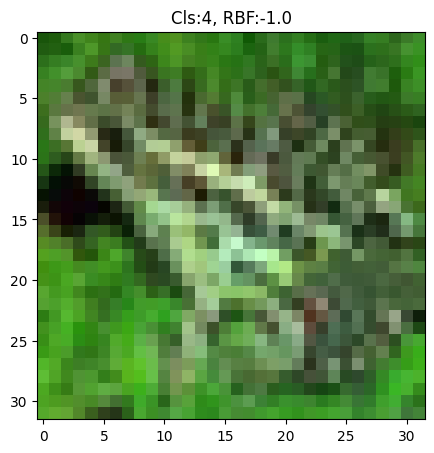

In [48]:
title = f'Cls:{pred_labels_base[idx]}, RBF:{pred_labels_base_rbf[idx]}'
imshow(images_cw_base[0][idx], title=title)

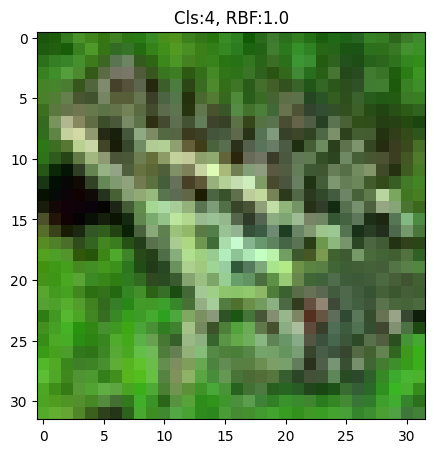

In [49]:
title = f'Cls:{pred_labels_integrated[idx]}, RBF:{pred_labels_integrated_rbf[idx]}'
imshow(images_cw_rbf[0][idx], title=title)

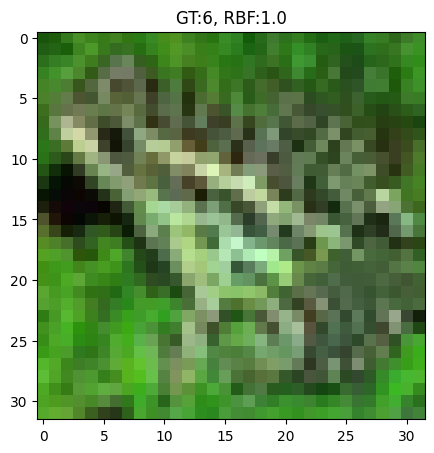

In [50]:
title = f'GT:{true_labels_base[idx]}, RBF:{pred_labels_benign_rbf[idx]}'
imshow(images_benign[0][idx], title=title)

# Compute pixel-wise metrics


In [51]:
MSELoss_none = nn.MSELoss(reduction='none')
MSELoss = nn.MSELoss(reduction='mean')
flatten = nn.Flatten()

In [52]:
l2_loss_base_per_sample = MSELoss_none(flatten(images_cw_base[0]), flatten(images_benign[0]))
l2_loss_base_per_sample = l2_loss_base_per_sample.sum(dim=1).mean()

l2_loss_integrated_per_sample = MSELoss_none(flatten(images_cw_rbf[0]), flatten(images_benign[0]))
l2_loss_integrated_per_sample = l2_loss_integrated_per_sample.sum(dim=1).mean()
print(f"L2 Ball : Base {l2_loss_base_per_sample}, Integrated : {l2_loss_integrated_per_sample}")

L2 Ball : Base 0.06947403401136398, Integrated : 0.14402754604816437


In [53]:
l2_loss_base = MSELoss(flatten(images_cw_base[0]), flatten(images_benign[0]))
l2_loss_rbf = MSELoss(flatten(images_cw_rbf[0]), flatten(images_benign[0]))
print(f"Mean Per pixel : Base {l2_loss_base}, Integrated : {l2_loss_rbf}")

Mean Per pixel : Base 2.2615246052737348e-05, Integrated : 4.6883971663191915e-05


In [54]:
l2_loss_base = MSELoss_none(flatten(images_cw_base[0]), flatten(images_benign[0]))
l2_loss_base = torch.max(l2_loss_base, dim=1)[0]
l2_loss_base = l2_loss_base.mean().item()

l2_loss_rbf = MSELoss_none(flatten(images_cw_rbf[0]), flatten(images_benign[0]))
l2_loss_rbf = torch.max(l2_loss_rbf, dim=1)[0]
l2_loss_rbf = l2_loss_rbf.mean().item()
print(f"Max pixel : Base {l2_loss_base}, Integrated : {l2_loss_rbf}")

Max pixel : Base 0.0008895640494301915, Integrated : 0.0011243070475757122


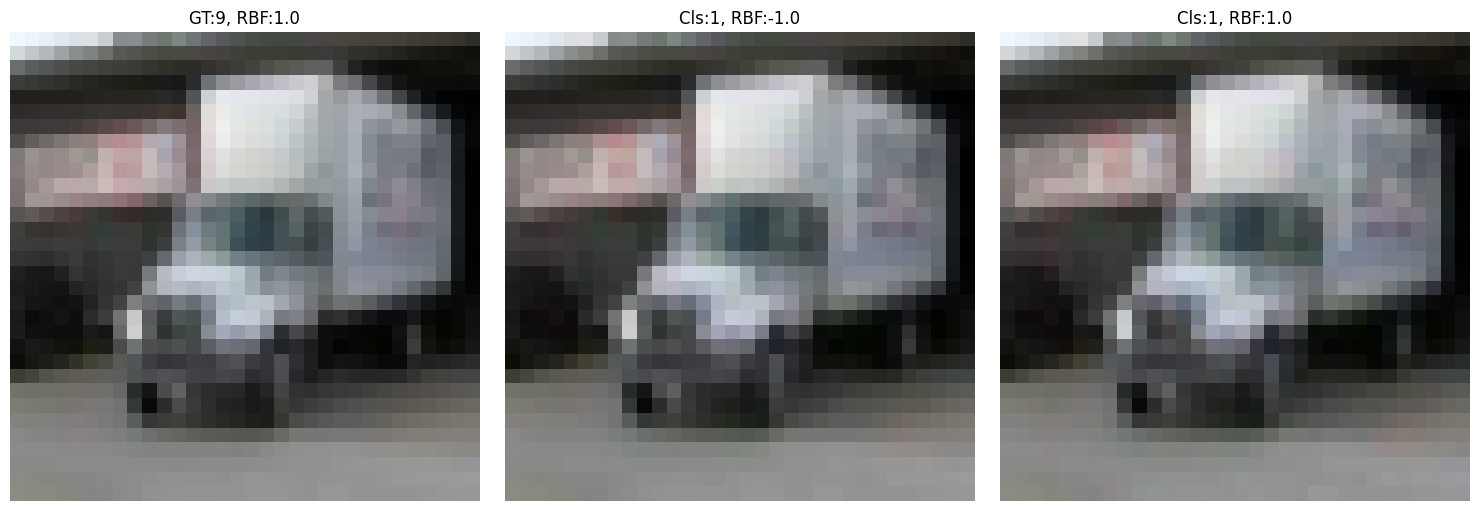

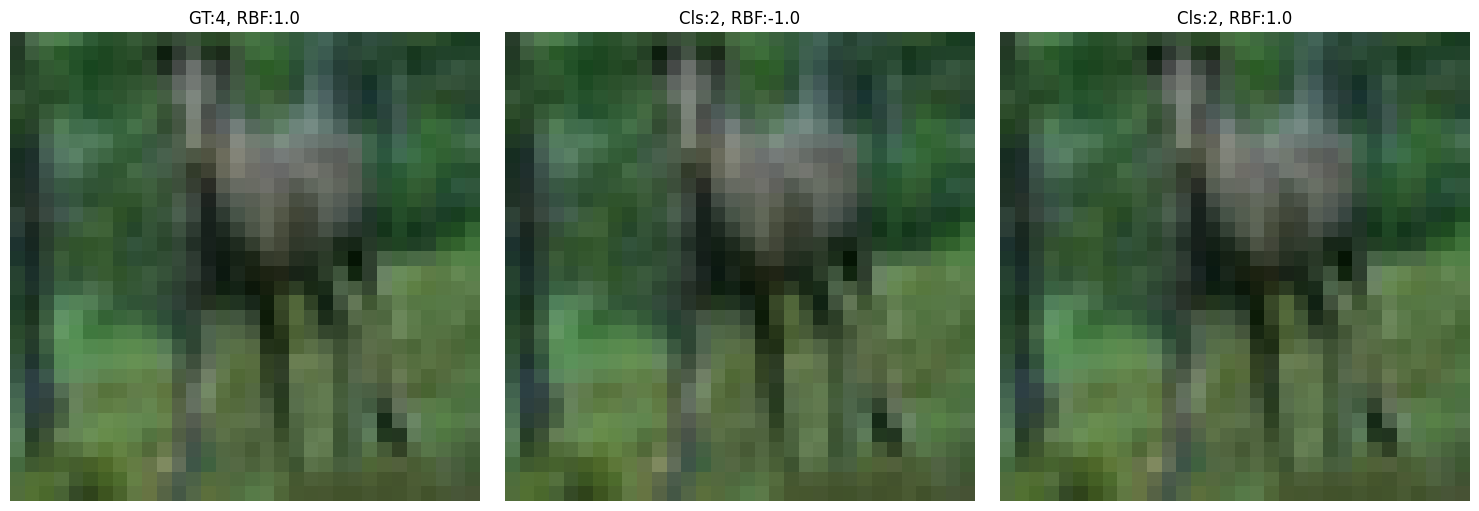

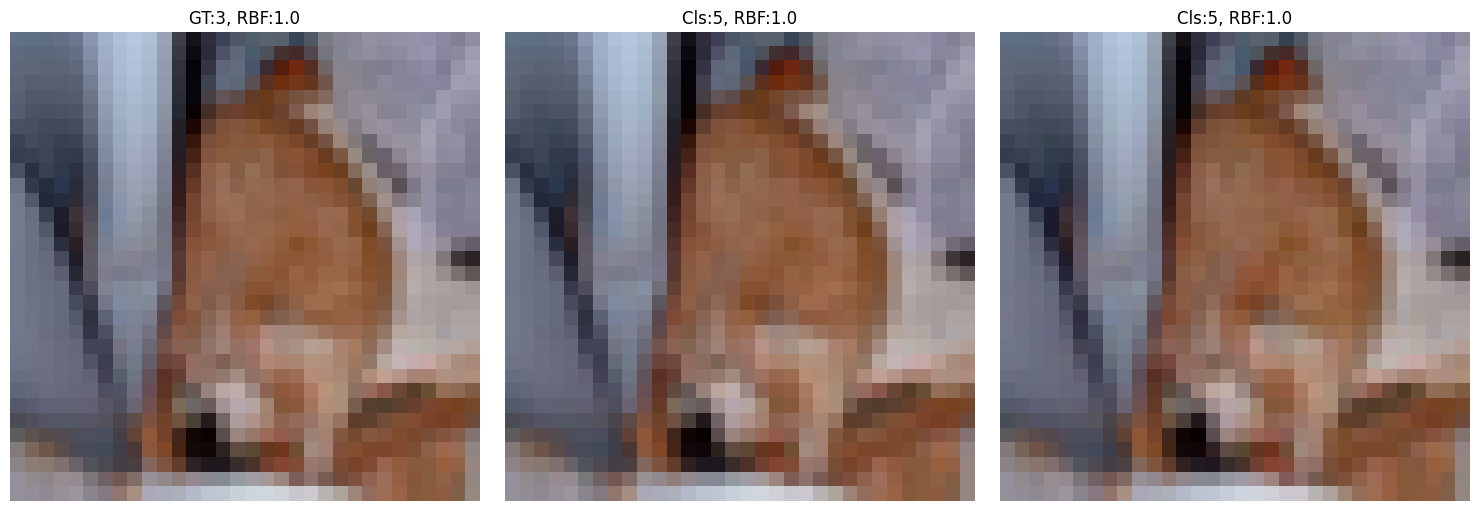

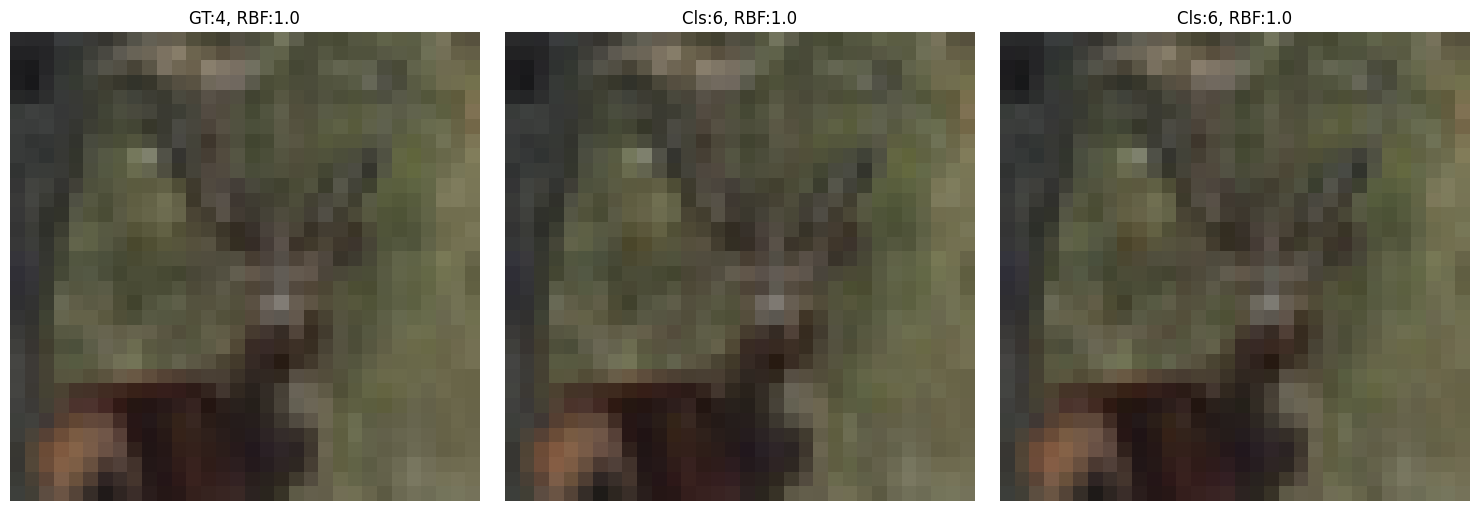

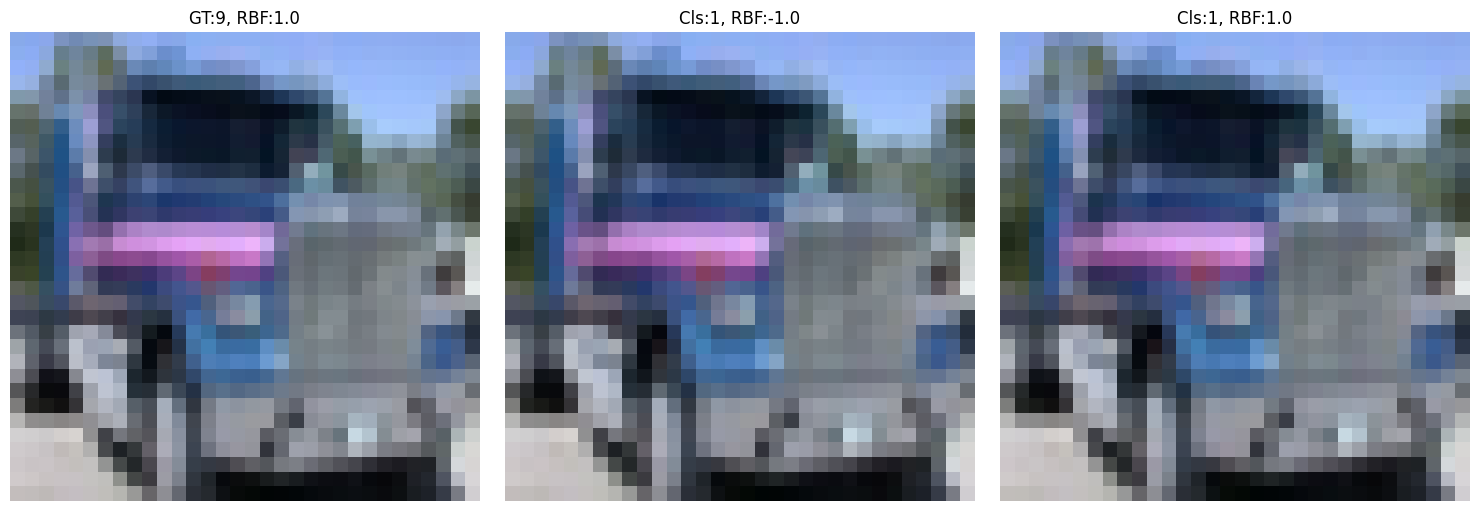

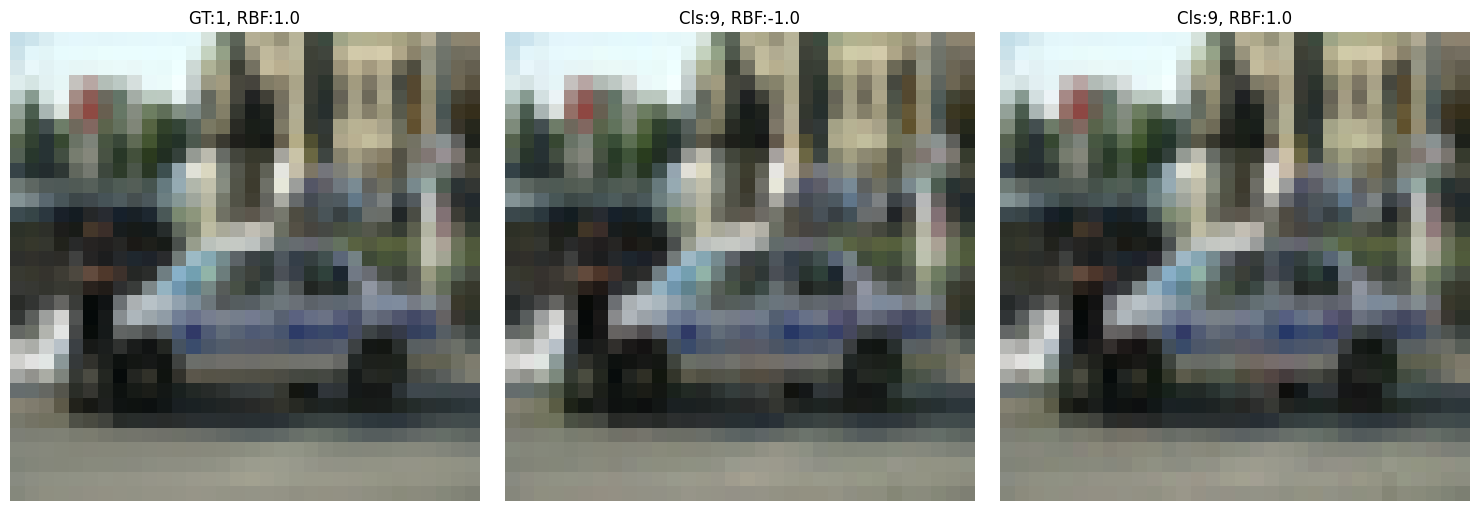

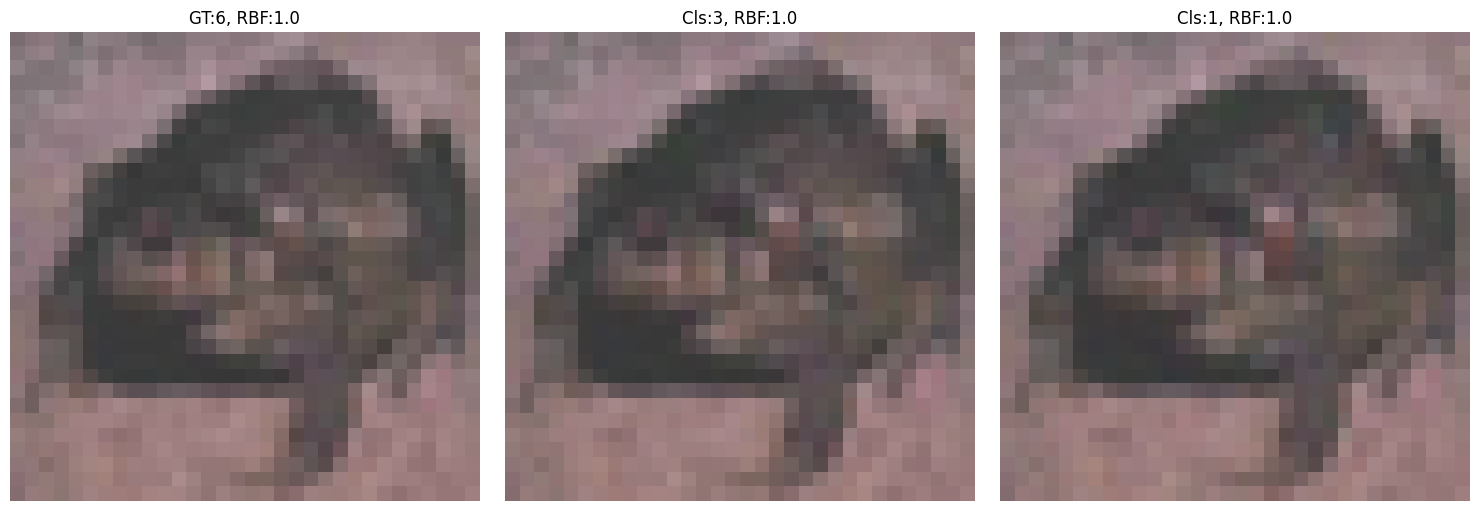

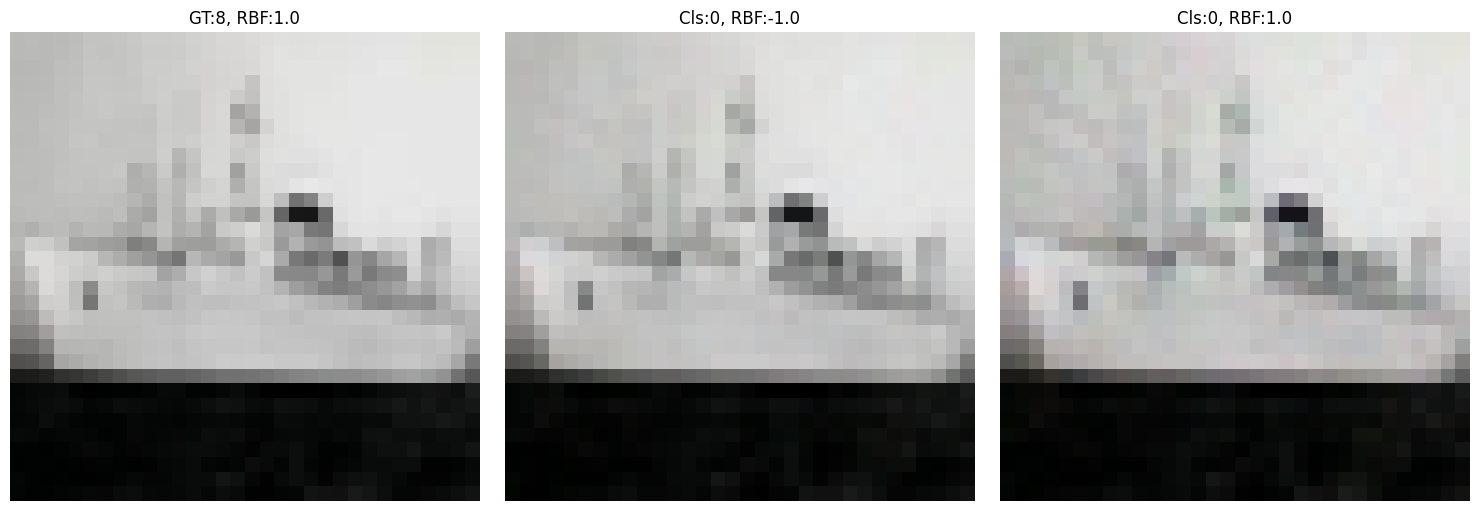

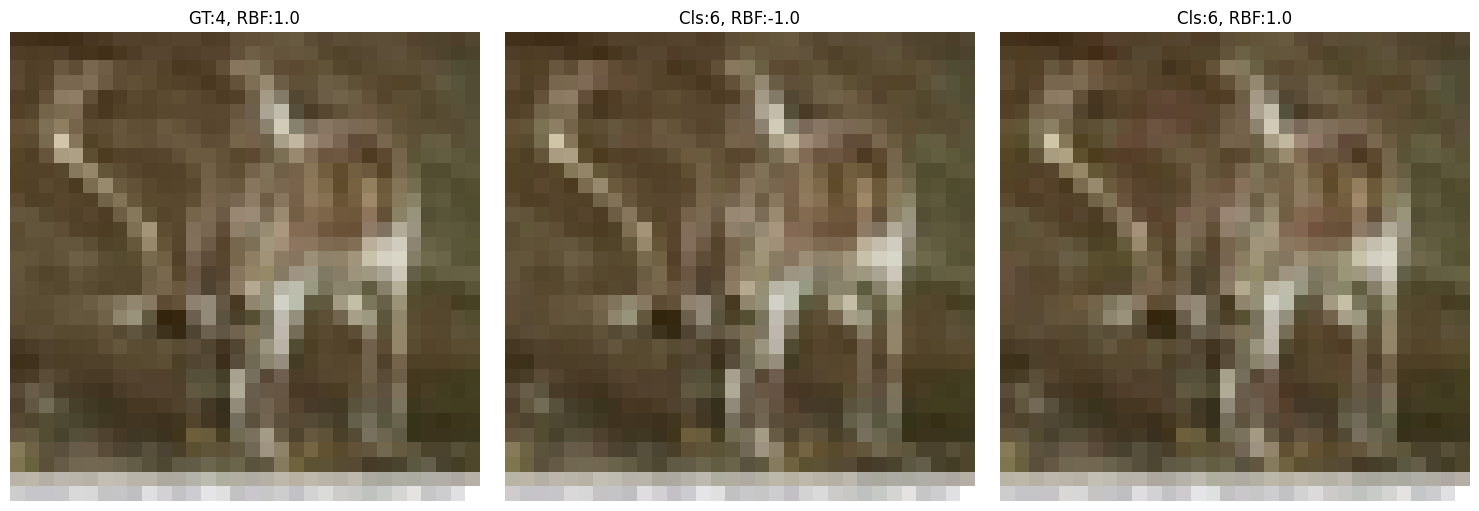

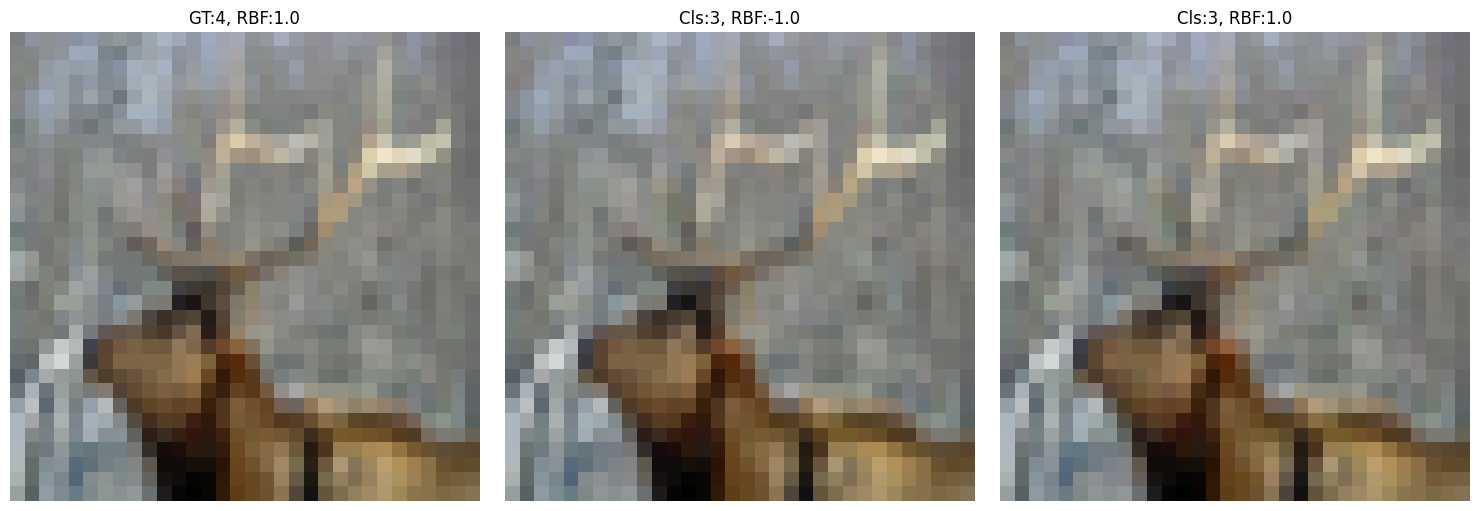

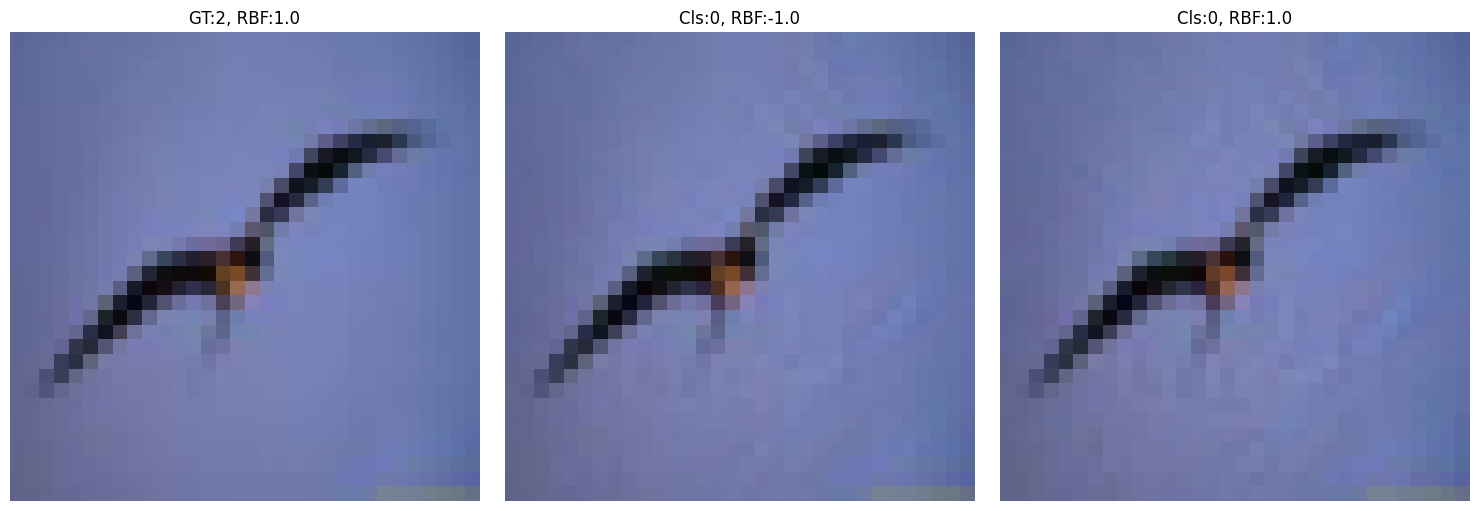

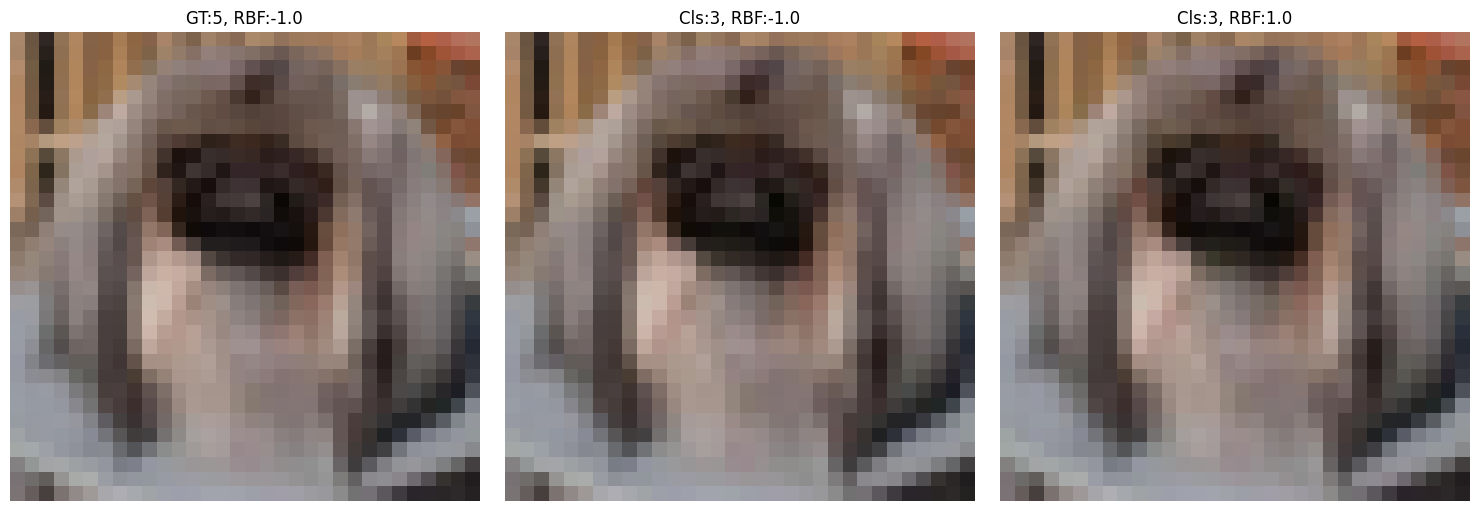

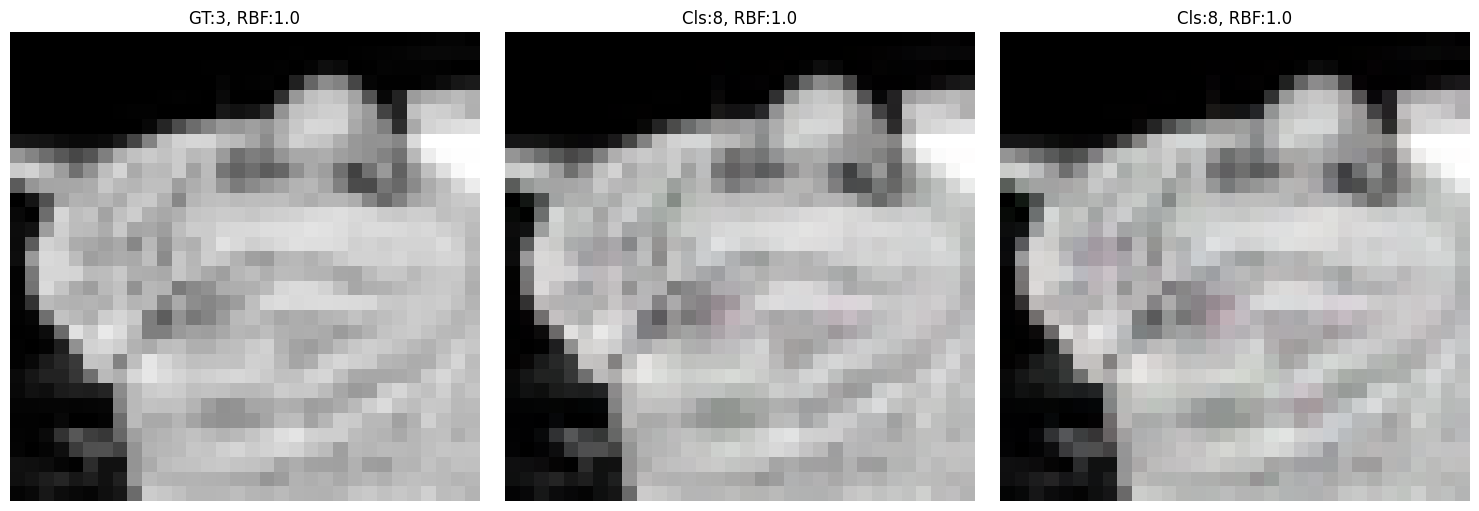

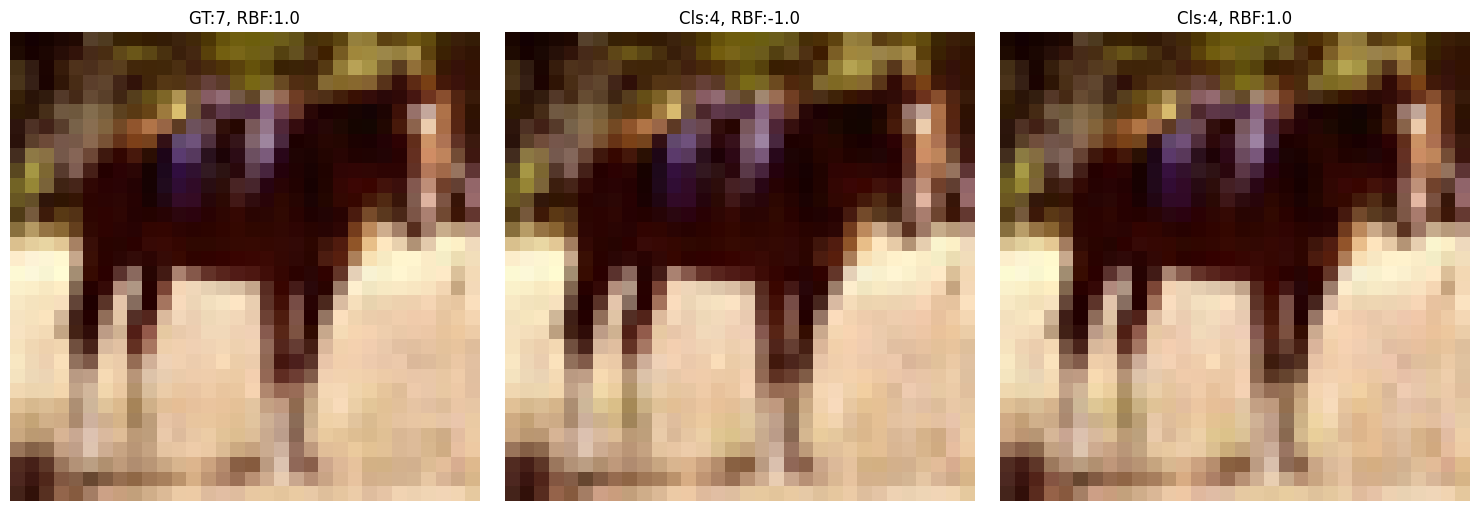

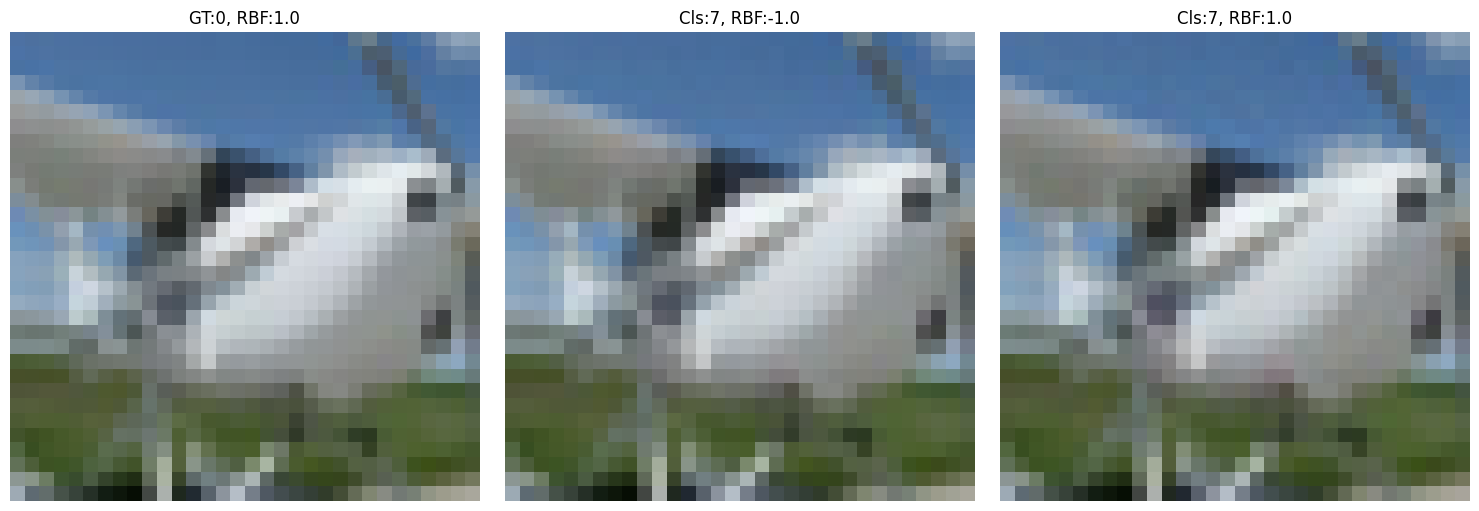

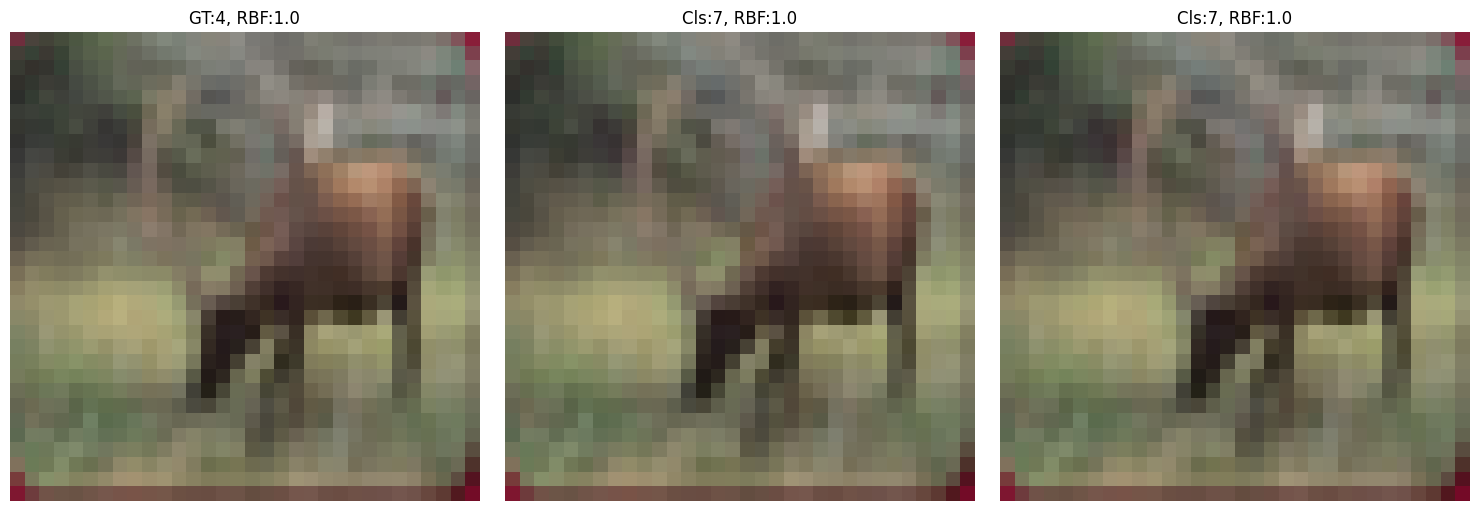

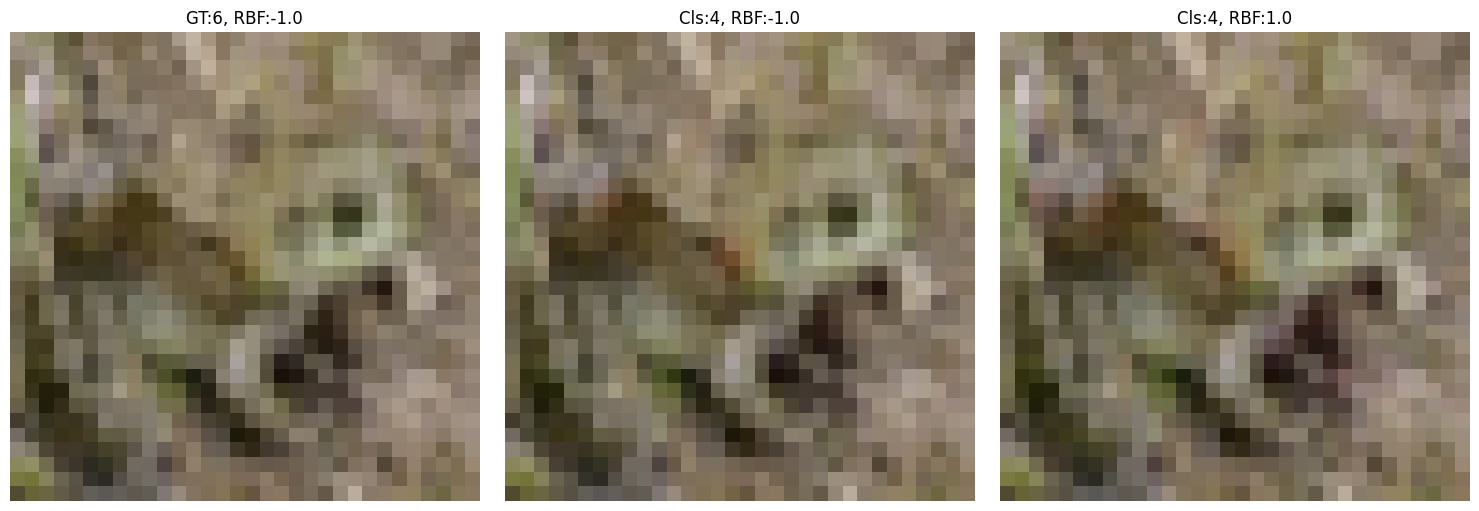

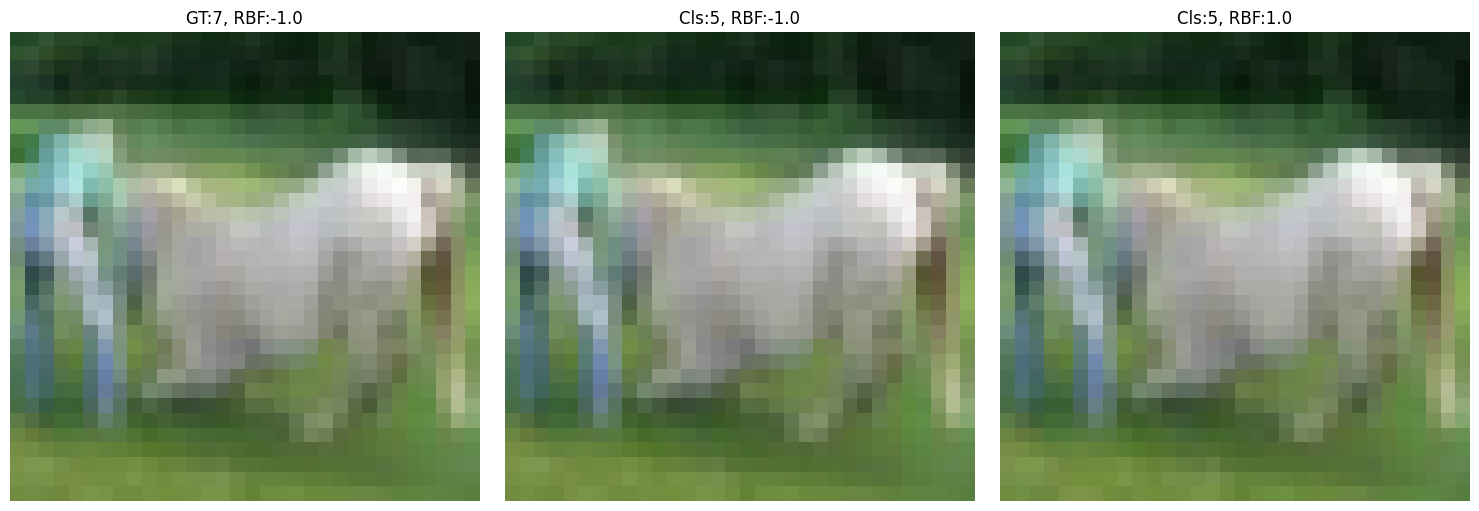

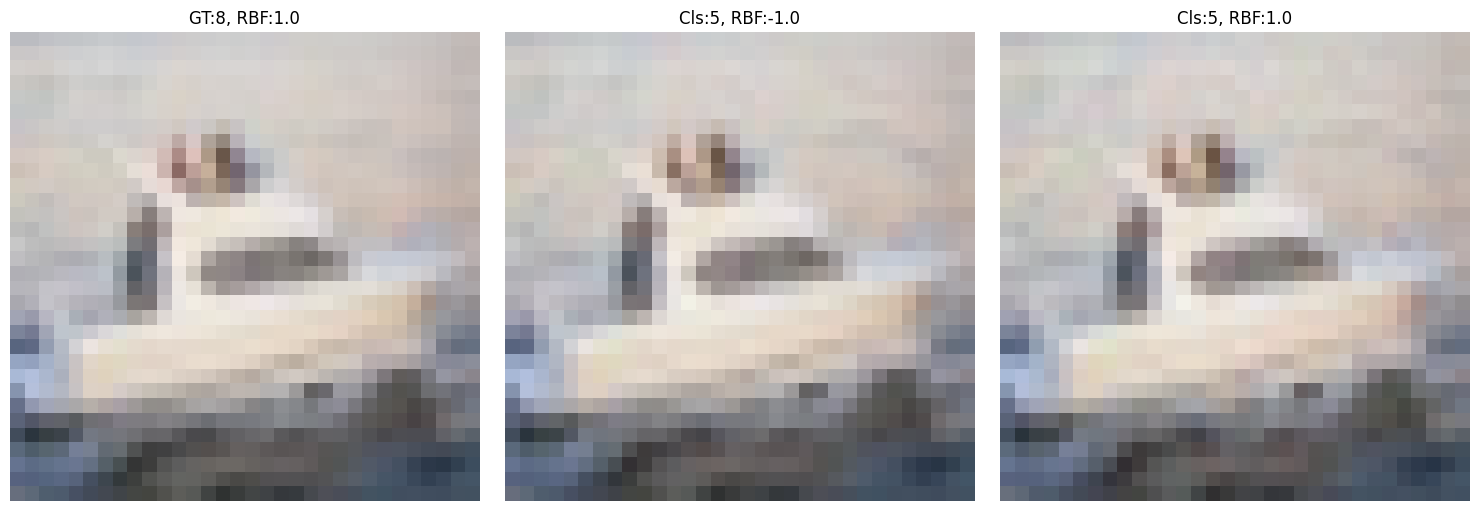

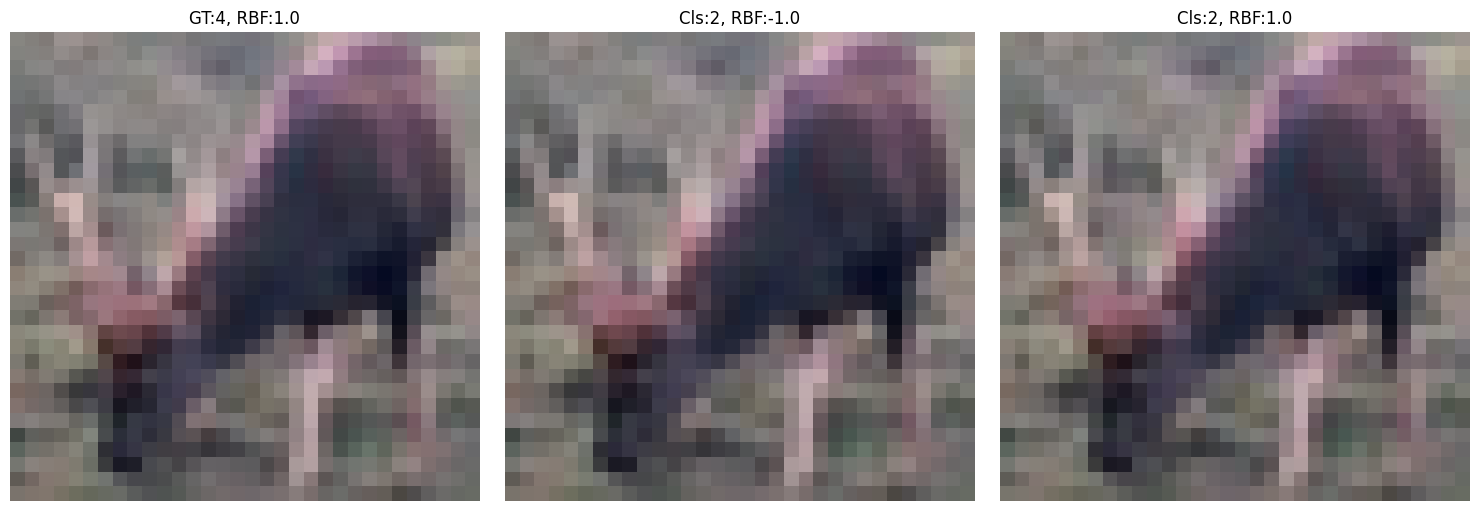

In [22]:
save_path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f/VisQuantized"

for idx in range(20):
    benign = images_benign[0][idx]
    cw_base = images_cw_base[0][idx]
    cw_rbf = images_cw_rbf[0][idx]

    benign = benign.swapaxes(0,1)
    benign = benign.swapaxes(1,2)

    cw_base = cw_base.swapaxes(0,1)
    cw_base = cw_base.swapaxes(1,2)

    cw_rbf = cw_rbf.swapaxes(0,1)
    cw_rbf = cw_rbf.swapaxes(1,2)

    title_benign = f'GT:{true_labels_base[idx]}, RBF:{pred_labels_benign_rbf[idx]}'
    title_base = f'Cls:{pred_labels_base[idx]}, RBF:{pred_labels_base_rbf[idx]}'
    title_integrated = f'Cls:{pred_labels_integrated[idx]}, RBF:{pred_labels_integrated_rbf[idx]}'
    titles = [title_benign, title_base, title_integrated]
    plot_side_by_side(benign, cw_base, cw_rbf, idx, save_path, titles=titles)

# Plots

### Accuracy vs Perturbation C

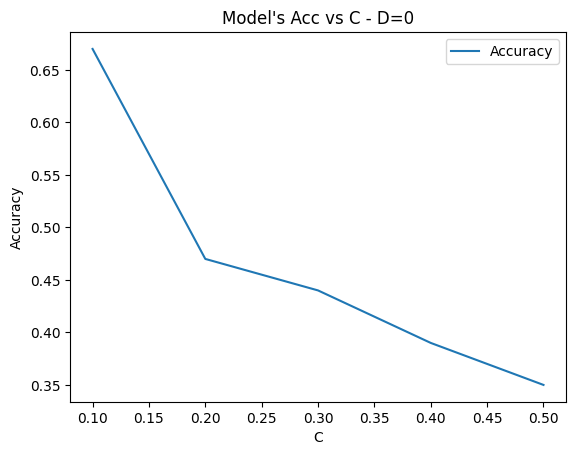

In [17]:
# Accuracy vs Perturbation C
d=0
type='Quantized'
acc = [0.67,0.47,0.44,0.39,0.35]
c = [0.1, 0.2, 0.3, 0.4, 0.5]
title=f"Model's Acc vs C - D={d}"
xlabel = "C"
ylabel = "Accuracy"
base_path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f/Plots"
config=f"acc_vs_pertur_d-{d}_type-{type}"

lineplot_acc_perturbation(c, acc,title, xlabel, ylabel, config, base_path)


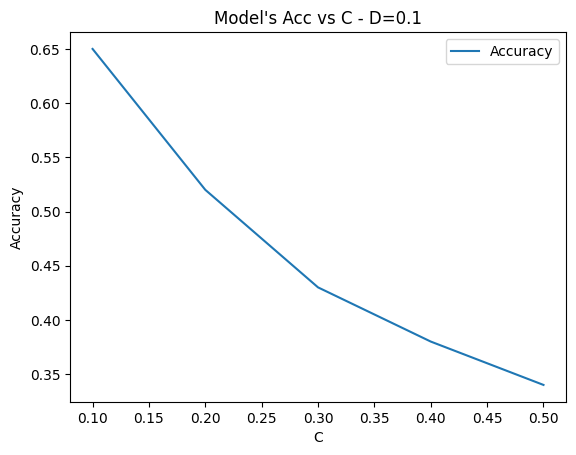

In [18]:
# Accuracy vs Perturbation C
d=0.1
type='Quantized'
acc = [0.65,0.52,0.43,0.38,0.34]
c = [0.1, 0.2, 0.3, 0.4, 0.5]
title=f"Model's Acc vs C - D={d}"
xlabel = "C"
ylabel = "Accuracy"
base_path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f/Plots"
config=f"acc_vs_pertur_d-{d}_type-{type}"

lineplot_acc_perturbation(c,acc,title, xlabel, ylabel, config, base_path)


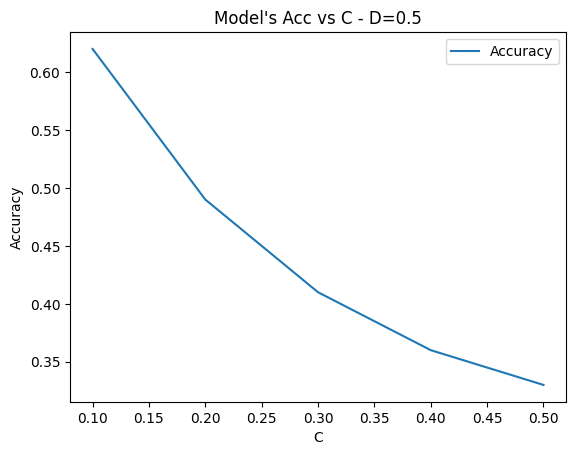

In [19]:
# Accuracy vs Perturbation C
d=0.5
type='Quantized'
acc = [0.62,0.49,0.41,0.36,0.33]
c = [0.1, 0.2, 0.3, 0.4, 0.5]
title=f"Model's Acc vs C - D={d}"
xlabel = "C"
ylabel = "Accuracy"
base_path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f/Plots"
config=f"acc_vs_pertur_d-{d}_type-{type}"

lineplot_acc_perturbation(c, acc,title, xlabel, ylabel, config, base_path)


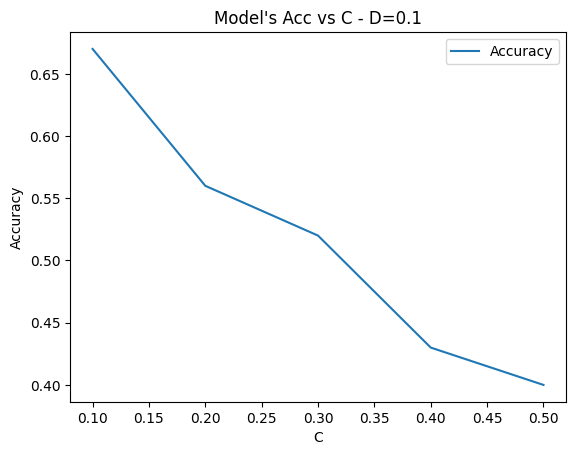

In [55]:
# Accuracy vs Perturbation C
d=0.1
type='Quantized'


acc = [0.67,0.56,0.52,0.43,0.4]
c = [0.1, 0.2, 0.3, 0.4, 0.5]
title=f"Model's Acc vs C - D={d}"

xlabel = "C"
ylabel = "Accuracy"
base_path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f/Plots"
config=f"acc_vs_pertur_d-{d}_type-{type}"

lineplot_acc_perturbation(c, acc,title, xlabel, ylabel, config, base_path)


## L2-radius vs Perturbation (C)

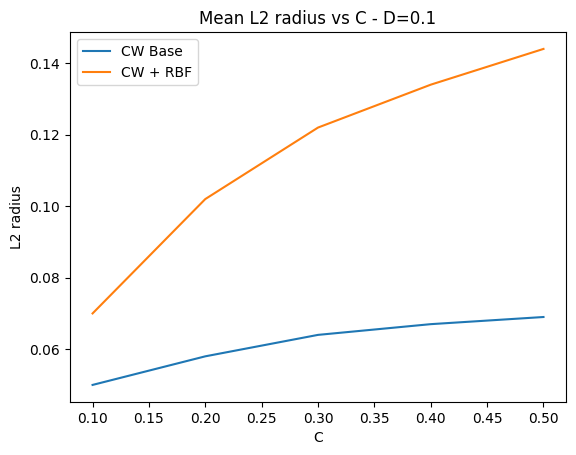

In [56]:
# Accuracy vs Perturbation C
d=0.1
type='Quantized'
base_l2 = [0.05,0.058,0.064,0.067,0.069]
integrated_l2 =[0.07,0.102,0.122,0.134,0.144]

c = [0.1, 0.2, 0.3, 0.4, 0.5]
title=f"Mean L2 radius vs C - D={d}"
xlabel = "C"
ylabel = "L2 radius"
base_path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f/Plots"
config=f"l2radius_vs_pertur_d-{d}_type-{type}"

lineplot_l2radius_perturbation(c,base_l2, integrated_l2, title, xlabel, ylabel, config, base_path)


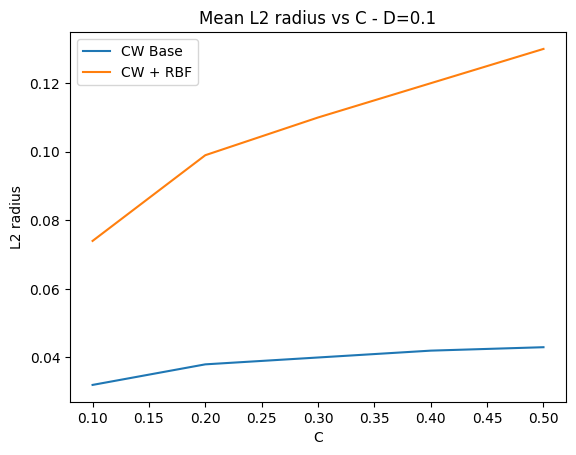

In [21]:
# Accuracy vs Perturbation C
d=0.1
type='Quantized'
base_l2 = [0.032,0.038,0.04,0.042,0.043]
integrated_l2 =[0.074,0.099,0.11,0.12,0.13]

c = [0.1, 0.2, 0.3, 0.4, 0.5]
title=f"Mean L2 radius vs C - D={d}"
xlabel = "C"
ylabel = "L2 radius"
base_path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f/Plots"
config=f"l2radius_vs_pertur_d-{d}_type-{type}"

lineplot_l2radius_perturbation(c,base_l2, integrated_l2, title, xlabel, ylabel, config, base_path)


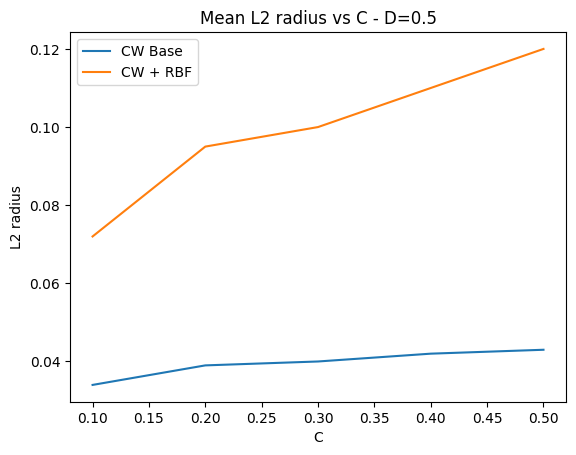

In [22]:
# Accuracy vs Perturbation C
d=0.5
type='Quantized'
base_l2 = [0.034,0.039,0.04,0.042,0.043]
integrated_l2 =[0.072,0.095,0.1,0.11,0.12]

c = [0.1, 0.2, 0.3, 0.4, 0.5]
title=f"Mean L2 radius vs C - D={d}"
xlabel = "C"
ylabel = "L2 radius"
base_path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f/Plots"
config=f"l2radius_vs_pertur_d-{d}_type-{type}"

lineplot_l2radius_perturbation(c,base_l2, integrated_l2, title, xlabel, ylabel, config, base_path)


# Per Pixel MSE vs Perturbation C

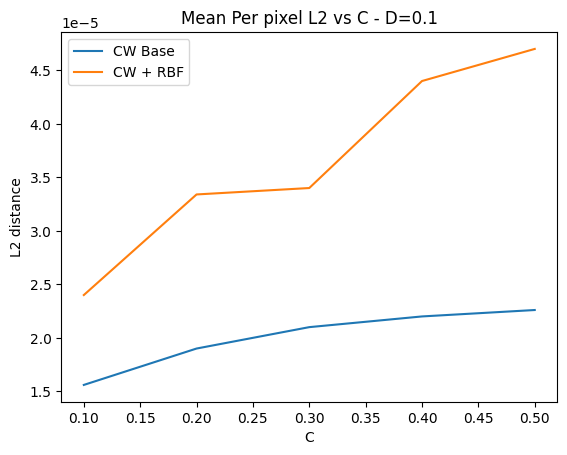

In [58]:
# Accuracy vs Perturbation C
d=0.1
type='Quantized'
base_l2 = [1.56e-05,1.9e-05,2.1e-05,2.2e-05,2.26e-05]
integrated_l2 =[2.4e-05,3.34e-05,3.4e-05,4.4e-05,4.7e-05]

c = [0.1, 0.2, 0.3, 0.4, 0.5]
title=f"Mean Per pixel L2 vs C - D={d}"
xlabel = "C"
ylabel = "L2 distance"
base_path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f/Plots"
config=f"l2distance_vs_pertur_d-{d}_type-{type}"

lineplot_l2radius_perturbation(c,base_l2, integrated_l2, title, xlabel, ylabel, config, base_path)


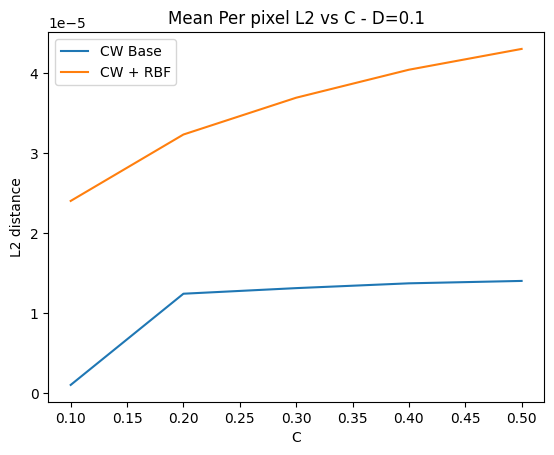

In [30]:
# Accuracy vs Perturbation C
d=0.1
type='Quantized'
base_l2 = [1e-06,1.24e-05,1.31e-05,1.37e-05,1.4e-05]
integrated_l2 =[2.4e-05,3.23e-05,3.69e-05,4.04e-05,4.3e-05]

c = [0.1, 0.2, 0.3, 0.4, 0.5]
title=f"Mean Per pixel L2 vs C - D={d}"
xlabel = "C"
ylabel = "L2 distance"
base_path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f/Plots"
config=f"l2distance_vs_pertur_d-{d}_type-{type}"

lineplot_l2radius_perturbation(c,base_l2, integrated_l2, title, xlabel, ylabel, config, base_path)


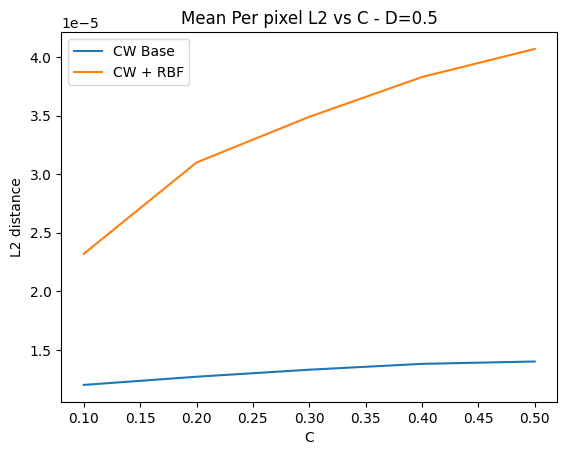

In [31]:
# Accuracy vs Perturbation C
d=0.5
type='Quantized'
base_l2 = [1.2e-05,1.27e-05,1.33e-05,1.38e-05,1.4e-05]
integrated_l2 =[2.32e-05,3.1e-05,3.49e-05,3.83e-05,4.07e-05]

c = [0.1, 0.2, 0.3, 0.4, 0.5]
title=f"Mean Per pixel L2 vs C - D={d}"
xlabel = "C"
ylabel = "L2 distance"
base_path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f/Plots"
config=f"l2distance_vs_pertur_d-{d}_type-{type}"

lineplot_l2radius_perturbation(c,base_l2, integrated_l2, title, xlabel, ylabel, config, base_path)


# Mean Max Pixel vs Perturbation (C)

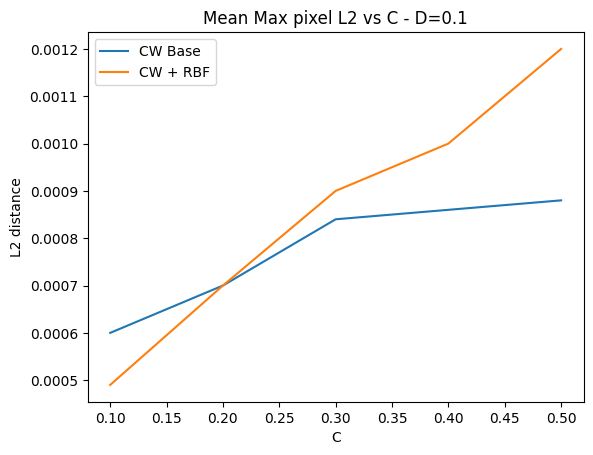

In [59]:
# Accuracy vs Perturbation C
d=0.1
type='Quantized'
base_l2 = [0.0006,0.0007,0.00084,0.00086,0.00088]
integrated_l2 =[0.00049,0.0007,0.0009,0.001,0.0012]

c = [0.1, 0.2, 0.3, 0.4, 0.5]
title=f"Mean Max pixel L2 vs C - D={d}"
xlabel = "C"
ylabel = "L2 distance"
base_path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f/Plots"
config=f"maxl2distance_vs_pertur_d-{d}_type-{type}"

lineplot_l2radius_perturbation(c,base_l2, integrated_l2, title, xlabel, ylabel, config, base_path)


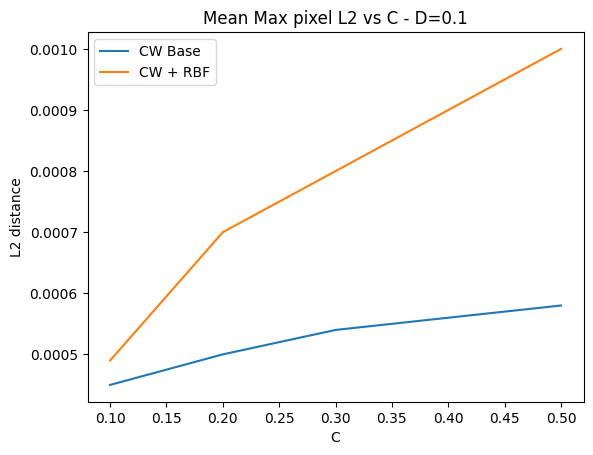

In [8]:
# Accuracy vs Perturbation C
d=0.1
type='Quantized'
base_l2 = [0.00045,0.0005,0.00054,0.00056,0.00058]
integrated_l2 =[0.00049,0.0007,0.0008,0.0009,0.001]

c = [0.1, 0.2, 0.3, 0.4, 0.5]
title=f"Mean Max pixel L2 vs C - D={d}"
xlabel = "C"
ylabel = "L2 distance"
base_path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f/Plots"
config=f"maxl2distance_vs_pertur_d-{d}_type-{type}"

lineplot_l2radius_perturbation(c,base_l2, integrated_l2, title, xlabel, ylabel, config, base_path)


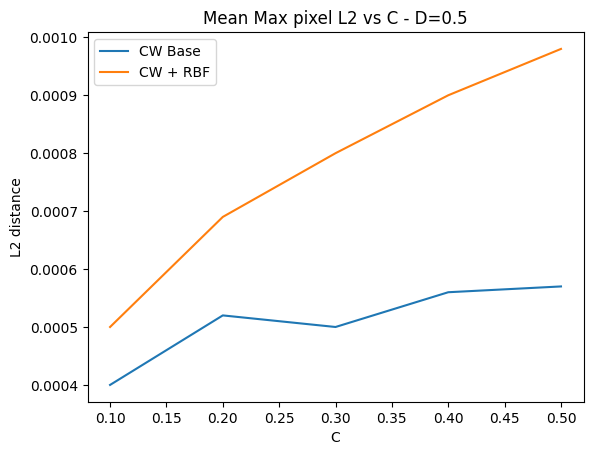

In [9]:
# Accuracy vs Perturbation C
d=0.5
type='Quantized'
base_l2 = [0.0004,0.00052,0.0005,0.00056,0.00057]
integrated_l2 =[0.0005,0.00069,0.0008,0.0009,0.00098]

c = [0.1, 0.2, 0.3, 0.4, 0.5]
title=f"Mean Max pixel L2 vs C - D={d}"
xlabel = "C"
ylabel = "L2 distance"
base_path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f/Plots"
config=f"maxl2distance_vs_pertur_d-{d}_type-{type}"

lineplot_l2radius_perturbation(c,base_l2, integrated_l2, title, xlabel, ylabel, config, base_path)


# MLP vs ResNet

In [5]:
detector = 'Regular'
c_base=0.5
d_base=0.0
c_integrated=0.2
d_integrated=0.1

base_path = f"/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f/MT_Baseline_a75d060c2415e722a953e03729658a14"
images_cw_base = f"Adversarial_Datasets/CW_adv_samples_5120_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}.pickle"
#images_cw_rbf = f"Adversarial_Datasets/CW_adv_samples_5120_test_detector-type-{detector}_integrated-True_c-{c_integrated}_d-{d_integrated}.pickle"
images_benign = f"Benign_Datasets/CW_benign_samples_5120_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}.pickle"

#predictions_integrated = f"Predictions/Model/CW_type-adversarial_5120_test_detector-type-{detector}_integrated-True_c-{c_integrated}_d-{d_integrated}.pickle"
predictions_base = f"Predictions/Model/CW_type-adversarial_5120_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}.pickle"

"""
predictions_benign_rbf = f"Predictions/RBF/CW_type-benign_5120_test_detector-type-{detector}_integrated-False_rbf_c-{c_base}_d-{d_base}.pickle"
predictions_base_rbf = f"Predictions/RBF/CW_type-adversarial_5120_test_detector-type-{detector}_integrated-False_rbf_c-{c_base}_d-{d_base}.pickle"
predictions_integrated_rbf = f"Predictions/RBF/CW_type-adversarial_5120_test_detector-type-{detector}_integrated-True_rbf_c-{c_integrated}_d-{d_integrated}.pickle"
"""

filtered_indices_base = f"Predictions/Perturbed_Samples/CW_benign_samples_5120_test_detector-type-{detector}_integrated-False_c-{c_base}_d-{d_base}.pt"
#filtered_indices_integrated = f"Predictions/Perturbed_Samples/CW_benign_samples_5120_test_detector-type-{detector}_integrated-True_c-{c_integrated}_d-{d_integrated}.pt" 

images_cw_base = os.path.join(base_path, images_cw_base)
#images_cw_rbf = os.path.join(base_path, images_cw_rbf)
images_benign = os.path.join(base_path, images_benign)
predictions_base_path = os.path.join(base_path, predictions_base)
#predictions_integrated_path = os.path.join(base_path, predictions_integrated)

#predictions_benign_rbf_path = os.path.join(base_path, predictions_benign_rbf)
#predictions_base_rbf_path = os.path.join(base_path, predictions_base_rbf)
#predictions_integrated_rbf_path = os.path.join(base_path, predictions_integrated_rbf)


filtered_indices_base_path = os.path.join(base_path, filtered_indices_base)
#filtered_indices_integrated_path = os.path.join(base_path, filtered_indices_integrated)




In [6]:
# Filter by common indices
filtered_indices_base = torch.load(filtered_indices_base_path)
#filtered_indices_integrated = torch.load(filtered_indices_integrated_path)


filtered_indices_base = [x.item() for x in filtered_indices_base]
#filtered_indices_integrated = [x.item() for x in filtered_indices_integrated]
base_indices = set(filtered_indices_base)
#integrated_indices = set(filtered_indices_integrated)
#common_indices = list(base_indices.intersection(integrated_indices))
common_indices = list(base_indices)

with open(images_cw_base, 'rb') as in_file:
    images_cw_base = pickle.load(in_file)
    images_cw_base[0] = images_cw_base[0][common_indices]
    images_cw_base[1] = images_cw_base[1][common_indices]
    

"""
with open(images_cw_rbf, 'rb') as in_file:
    images_cw_rbf = pickle.load(in_file)
    images_cw_rbf[0] = images_cw_rbf[0][common_indices]
    images_cw_rbf[1] = images_cw_rbf[1][common_indices]

"""
with open(images_benign, 'rb') as in_file:
    images_benign = pickle.load(in_file)
    images_benign[0] = images_benign[0][common_indices]
    images_benign[1] = images_benign[1][common_indices]




with open(predictions_base_path, 'rb') as in_file:
    predictions = pickle.load(in_file)
    true_labels_base = np.asarray(predictions['true_labels'])[common_indices]
    pred_labels_base = np.asarray(predictions['pred_labels'])[common_indices]

"""
with open(predictions_integrated_path, 'rb') as in_file:
    predictions = pickle.load(in_file)
    true_labels_integrated = np.asarray(predictions['true_labels'])[common_indices]
    pred_labels_integrated = np.asarray(predictions['pred_labels'])[common_indices]
"""
"""
with open(predictions_benign_rbf_path, 'rb') as in_file:
    predictions = pickle.load(in_file)
    true_labels_benign_rbf = np.asarray(predictions['true_labels'])[common_indices]
    pred_labels_benign_rbf = np.asarray(predictions['pred_labels'])[common_indices]
    pred_scores_benign_rbf = np.asarray(predictions['pred_scores'])[common_indices]

with open(predictions_base_rbf_path, 'rb') as in_file:
    predictions = pickle.load(in_file)
    true_labels_base_rbf = np.asarray(predictions['true_labels'])[common_indices]
    pred_labels_base_rbf = np.asarray(predictions['pred_labels'])[common_indices]
    pred_scores_base_rbf = np.asarray(predictions['pred_scores'])[common_indices]

    
with open(predictions_integrated_rbf_path, 'rb') as in_file:
    predictions = pickle.load(in_file)
    true_labels_integrated_rbf = np.asarray(predictions['true_labels'])[common_indices]
    pred_labels_integrated_rbf = np.asarray(predictions['pred_labels'])[common_indices]
    pred_scores_integrated_rbf = np.asarray(predictions['pred_scores'])[common_indices]
"""



"\nwith open(predictions_benign_rbf_path, 'rb') as in_file:\n    predictions = pickle.load(in_file)\n    true_labels_benign_rbf = np.asarray(predictions['true_labels'])[common_indices]\n    pred_labels_benign_rbf = np.asarray(predictions['pred_labels'])[common_indices]\n    pred_scores_benign_rbf = np.asarray(predictions['pred_scores'])[common_indices]\n\nwith open(predictions_base_rbf_path, 'rb') as in_file:\n    predictions = pickle.load(in_file)\n    true_labels_base_rbf = np.asarray(predictions['true_labels'])[common_indices]\n    pred_labels_base_rbf = np.asarray(predictions['pred_labels'])[common_indices]\n    pred_scores_base_rbf = np.asarray(predictions['pred_scores'])[common_indices]\n\n    \nwith open(predictions_integrated_rbf_path, 'rb') as in_file:\n    predictions = pickle.load(in_file)\n    true_labels_integrated_rbf = np.asarray(predictions['true_labels'])[common_indices]\n    pred_labels_integrated_rbf = np.asarray(predictions['pred_labels'])[common_indices]\n    pred_

In [45]:
# Get distribution plots for all 3

benign_rbf_indices = np.where(pred_scores_benign_rbf > 0)[0]
base_rbf_indices = np.where(pred_scores_base_rbf > 0)[0]
integrated_rbf_indices = np.where(pred_scores_integrated_rbf > 0)[0]

NameError: name 'pred_scores_benign_rbf' is not defined

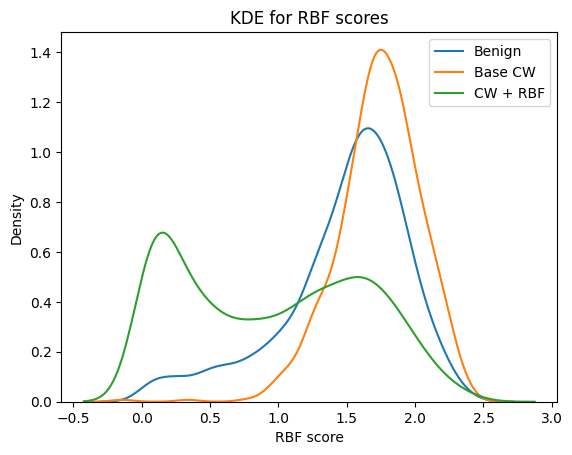

In [ ]:
sns.kdeplot(pred_scores_benign_rbf[benign_rbf_indices])
sns.kdeplot(pred_scores_benign_rbf[base_rbf_indices])
sns.kdeplot(pred_scores_integrated_rbf[integrated_rbf_indices])
plt.legend(labels=['Benign', "Base CW", "CW + RBF"])
plt.title("KDE for RBF scores")
plt.xlabel("RBF score")
config = f"KDE_{detector}_c_base-{c_base}_d-base-{d_base}_c_integrated-{c_integrated}_d_integrated-{d_integrated}.png"
path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f/Plots"
filename = os.path.join(path, config)
plt.savefig(filename, bbox_inches='tight')



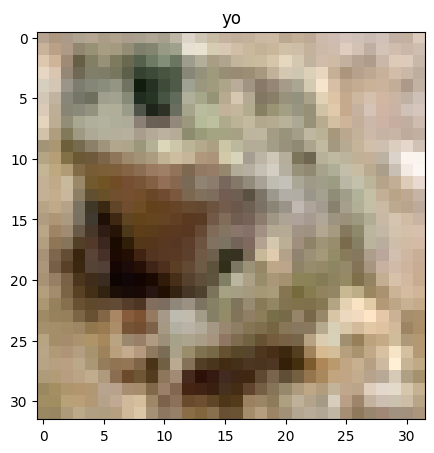

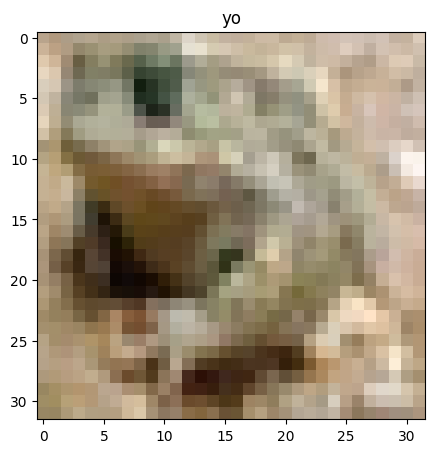

In [20]:
idx = 78
title="yo"
#title = f'Cls:{pred_labels_base[idx]}, RBF:{pred_labels_base_rbf[idx]}'
imshow(images_cw_base[0][idx], title=title)
#title = f'Cls:{pred_labels_integrated[idx]}, RBF:{pred_labels_integrated_rbf[idx]}'
#imshow(images_cw_rbf[0][idx], title=title)
#title = f'GT:{true_labels_base[idx]}, RBF:{pred_labels_benign_rbf[idx]}'
imshow(images_benign[0][idx], title=title)

# Compute pixel-wise metrics


In [7]:
MSELoss_none = nn.MSELoss(reduction='none')
MSELoss = nn.MSELoss(reduction='mean')
flatten = nn.Flatten()

In [8]:
l2_loss_base_per_sample = MSELoss_none(flatten(images_cw_base[0]), flatten(images_benign[0]))
l2_loss_base_per_sample = l2_loss_base_per_sample.sum(dim=1).mean()

#l2_loss_integrated_per_sample = MSELoss_none(flatten(images_cw_rbf[0]), flatten(images_benign[0]))
#l2_loss_integrated_per_sample = l2_loss_integrated_per_sample.sum(dim=1).mean()
#print(f"L2 Ball : Base {l2_loss_base_per_sample}, Integrated : {l2_loss_integrated_per_sample}")
print(f"L2 Ball : Base {l2_loss_base_per_sample}")

L2 Ball : Base 0.2165011167526245


In [9]:
l2_loss_base = MSELoss(flatten(images_cw_base[0]), flatten(images_benign[0]))
#l2_loss_rbf = MSELoss(flatten(images_cw_rbf[0]), flatten(images_benign[0]))
#print(f"Mean Per pixel : Base {l2_loss_base}, Integrated : {l2_loss_rbf}")
print(f"Mean Per pixel : Base {l2_loss_base}")

Mean Per pixel : Base 7.047562394291162e-05


In [10]:
l2_loss_base = MSELoss_none(flatten(images_cw_base[0]), flatten(images_benign[0]))
l2_loss_base = torch.max(l2_loss_base, dim=1)[0]
l2_loss_base = l2_loss_base.mean().item()

#l2_loss_rbf = MSELoss_none(flatten(images_cw_rbf[0]), flatten(images_benign[0]))
#l2_loss_rbf = torch.max(l2_loss_rbf, dim=1)[0]
#l2_loss_rbf = l2_loss_rbf.mean().item()
#print("Mean max pixel differene between CW RBF and benign is : ", l2_loss_rbf.item())
#print("Mean max pixel differene between CW base and benign is : ", l2_loss_base.item())
#print(f"Max pixel : Base {l2_loss_base}, Integrated : {l2_loss_rbf}")
print(f"Max pixel : Base {l2_loss_base}")

Max pixel : Base 0.00124730437528342


# Plots

In [16]:
import matplotlib.pyplot as plt

def plot_side_by_side(image1, image2, idx, save_path, titles=None):
    """
    Plots three images side by side.

    Args:
        image1 (np.ndarray): The first image.
        image2 (np.ndarray): The second image.
        image3 (np.ndarray): The third image.
        titles (list, optional): A list of titles for the images.

    Returns:
        None
    """

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].set_title(titles[0])
    axes[0].imshow(image1)
    axes[0].axis('off')
    axes[1].set_title(titles[1])
    axes[1].imshow(image2)
    axes[1].axis('off')
    
    plt.tight_layout()
    
    if save_path is not None:
        filename = os.path.join(save_path, f"{idx}.jpg")
        plt.savefig(filename, bbox_inches='tight')


    plt.show()

In [11]:
def lineplot_acc_perturbation(x, y1,y2, title, xlabel, ylabel, config, base_path):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x, y1, label='Accuracy - ResNet18')
    plt.plot(x, y2, label='Accuracy - MLP')
    plt.legend(loc='upper right')        
    filename = os.path.join(base_path, config + ".jpg")
    plt.savefig(filename, bbox_inches='tight')
    
def lineplot_l2radius_perturbation(x, y1, y2, title, xlabel, ylabel, config, base_path):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x, y1, label="ResNet18")
    plt.plot(x, y2, label="MLP")
    plt.legend(loc='upper left')
    filename = os.path.join(base_path, config + ".jpg")
    plt.savefig(filename, bbox_inches='tight')
    
    

### Accuracy vs Perturbation C

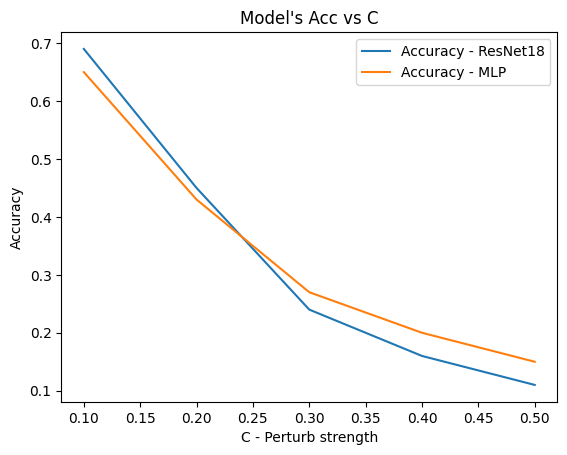

In [58]:
# Accuracy vs Perturbation C
d=0
type='Regular'
acc_resnet = [0.69,0.45,0.24, 0.16, 0.11]
acc_mlp = [0.65, 0.43, 0.27, 0.20, 0.15]

c = [0.1, 0.2, 0.3, 0.4, 0.5]
title=f"Model's Acc vs C"
xlabel = "C - Perturb strength"
ylabel = "Accuracy"
base_path = "/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f/MT_Baseline_a75d060c2415e722a953e03729658a14/Plots"
config=f"acc_vs_pertur_d-{d}_type-{type}"

lineplot_acc_perturbation(c, acc_resnet, acc_mlp,title, xlabel, ylabel, config, base_path)


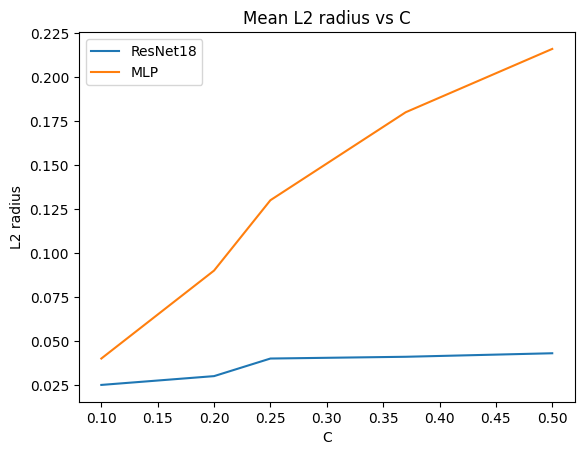

In [68]:

# Accuracy vs Perturbation C
d=0
type='Regular'
resnet_l2 = [0.025,0.03,0.04, 0.041,0.043]
mlp_l2 =[0.04, 0.09,0.13,0.18,0.216]

c = [0.1, 0.2, 0.25, 0.37, 0.5]
title=f"Mean L2 radius vs C"
xlabel = "C - Perturb strength"
ylabel = "L2 radius"
base_path = "/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f/MT_Baseline_a75d060c2415e722a953e03729658a14/Plots"
config=f"l2radius_vs_pertur_d-{d}_type-{type}"

lineplot_l2radius_perturbation(c,resnet_l2, mlp_l2, title, xlabel, ylabel, config, base_path)


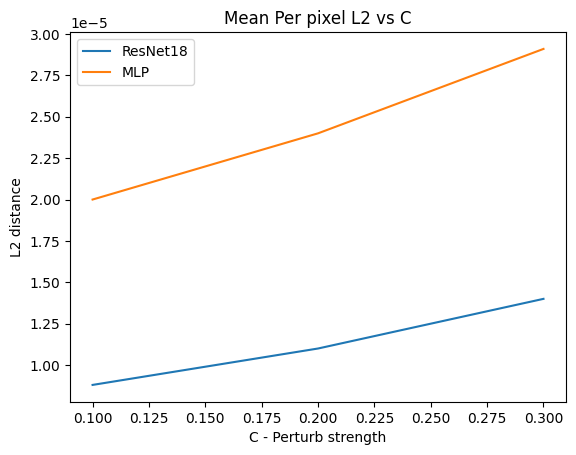

In [72]:
# Accuracy vs Perturbation C
d=0.1
type='Regular'
base_l2 = [8.8e-06,1.1e-05,1.4e-05]
integrated_l2 =[2.e-05,2.4e-05,2.91e-05]
c = [0.1, 0.2, 0.3]
title=f"Mean Per pixel L2 vs C"
xlabel = "C - Perturb strength"
ylabel = "L2 distance"
base_path = "/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f/MT_Baseline_a75d060c2415e722a953e03729658a14/Plots"
config=f"l2distance_vs_pertur_d-{d}_type-{type}"

lineplot_l2radius_perturbation(c,base_l2, integrated_l2, title, xlabel, ylabel, config, base_path)


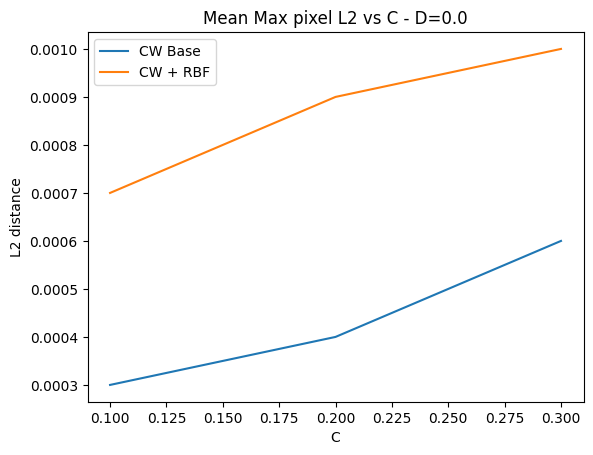

In [ ]:
# Accuracy vs Perturbation C
d=0.0
type='Regular'
base_l2 = [0.0003,0.0004,0.0006]
integrated_l2 =[0.0007,0.0009,0.001]

c = [0.1, 0.2, 0.3]
title=f"Mean Max pixel L2 vs C - D={d}"
xlabel = "C"
ylabel = "L2 distance"
base_path = "/bigstor/zsarwar/SparseDNNs/MT_CIFAR10_full_10_d5f3f545a0883adb9c8f98e2a6ba4ac7/MT_Baseline_32efd89f04333501e1d66bc4e1d4260f/Plots"
config=f"maxl2distance_vs_pertur_d-{d}_type-{type}"

lineplot_l2radius_perturbation(c,base_l2, integrated_l2, title, xlabel, ylabel, config, base_path)


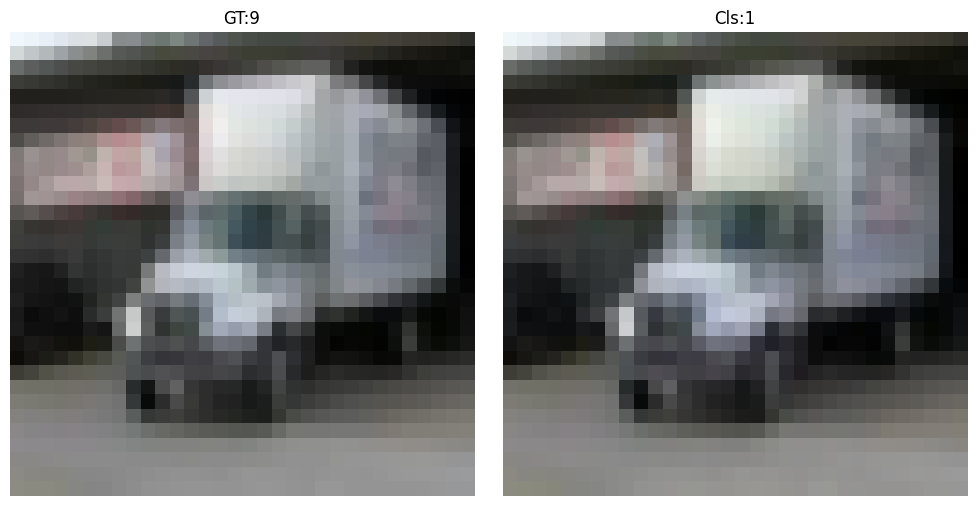

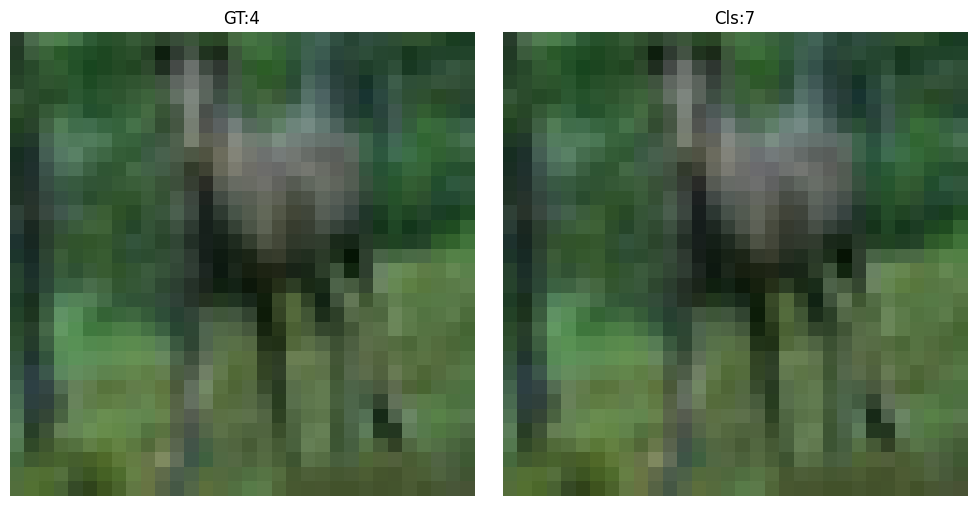

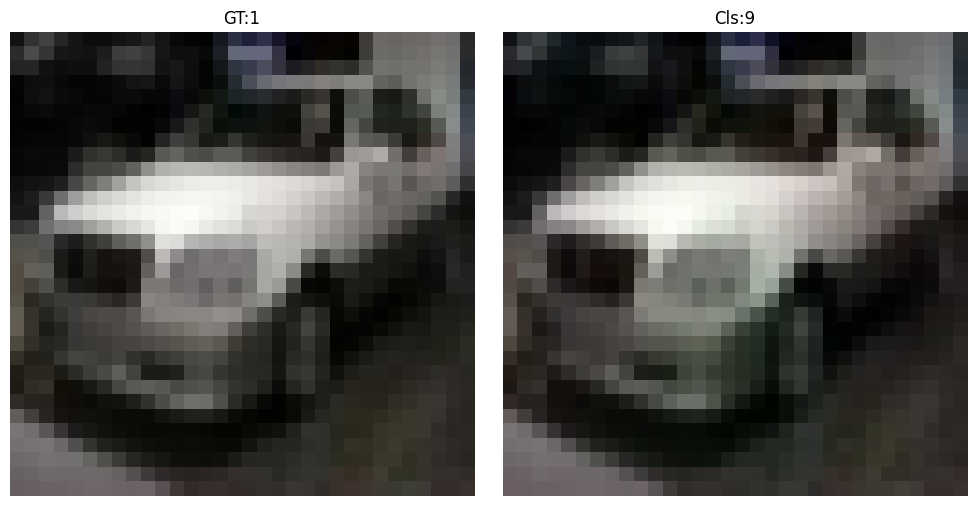

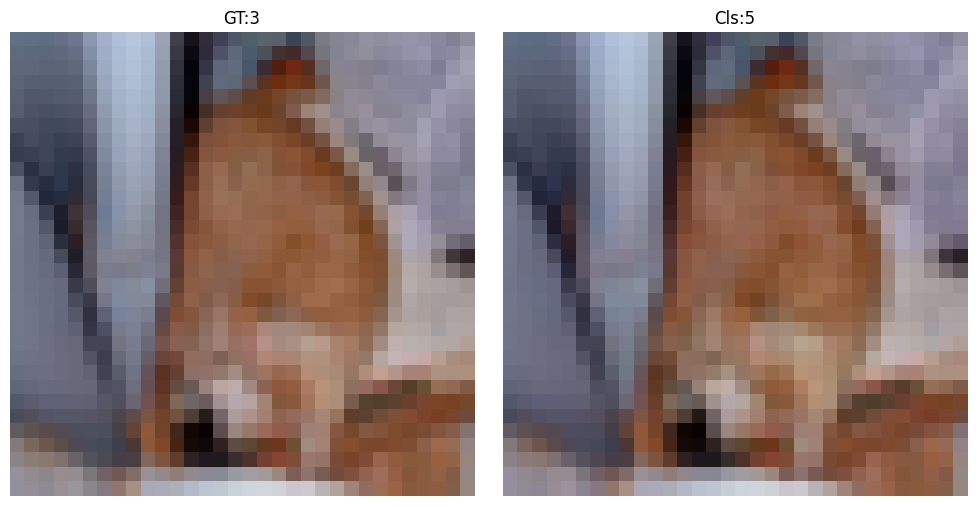

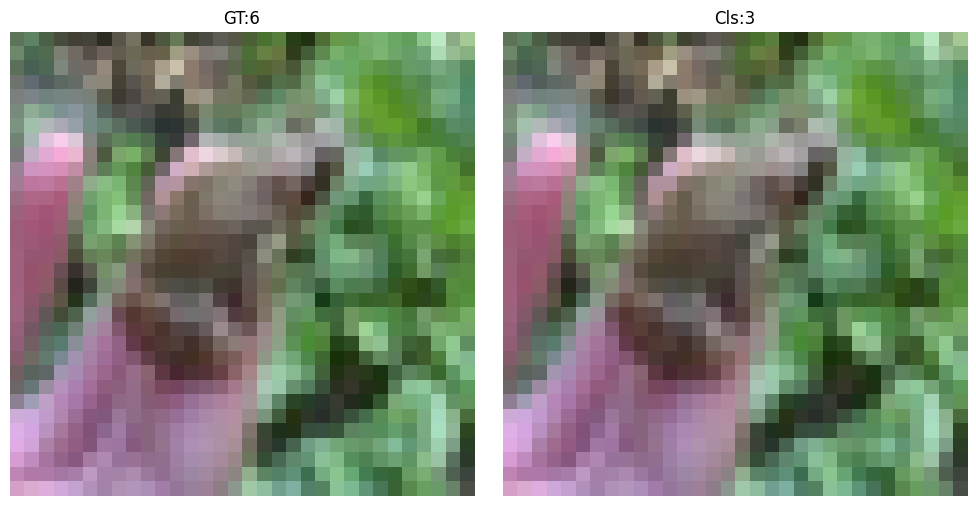

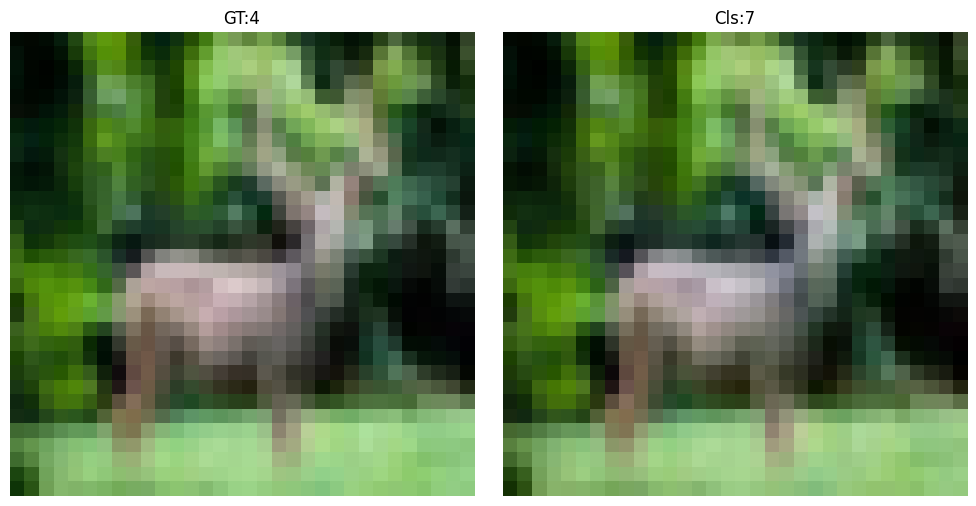

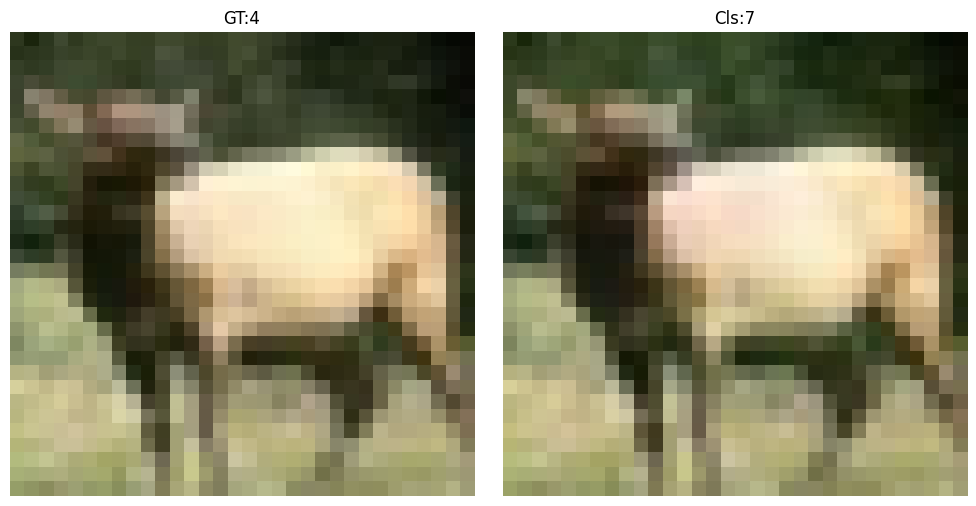

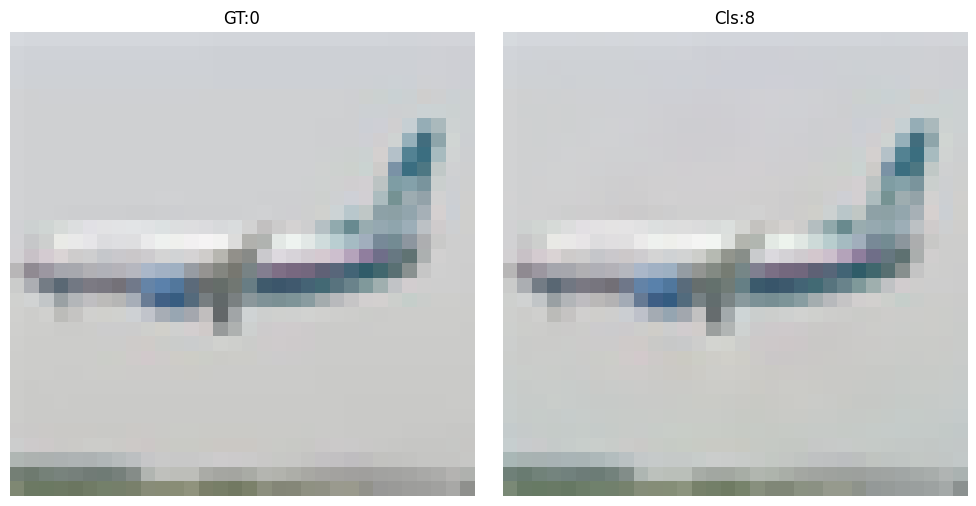

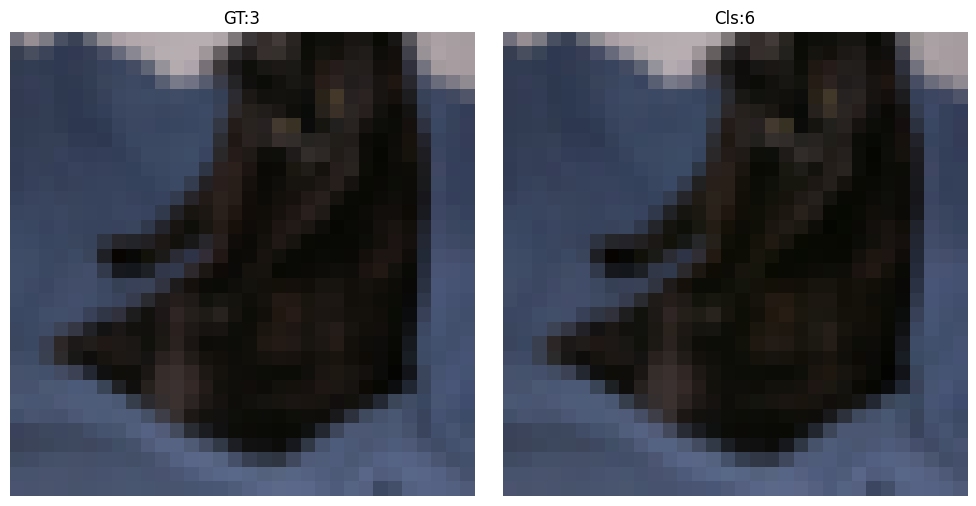

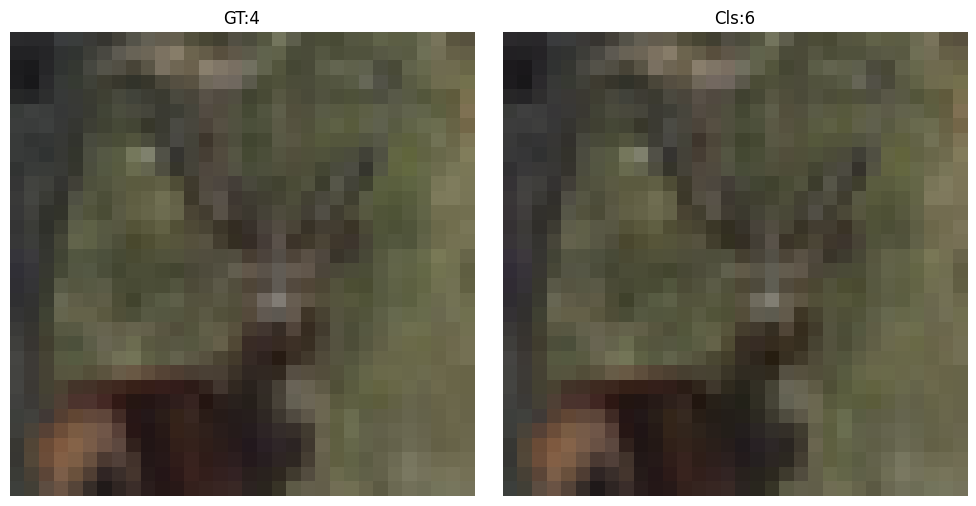

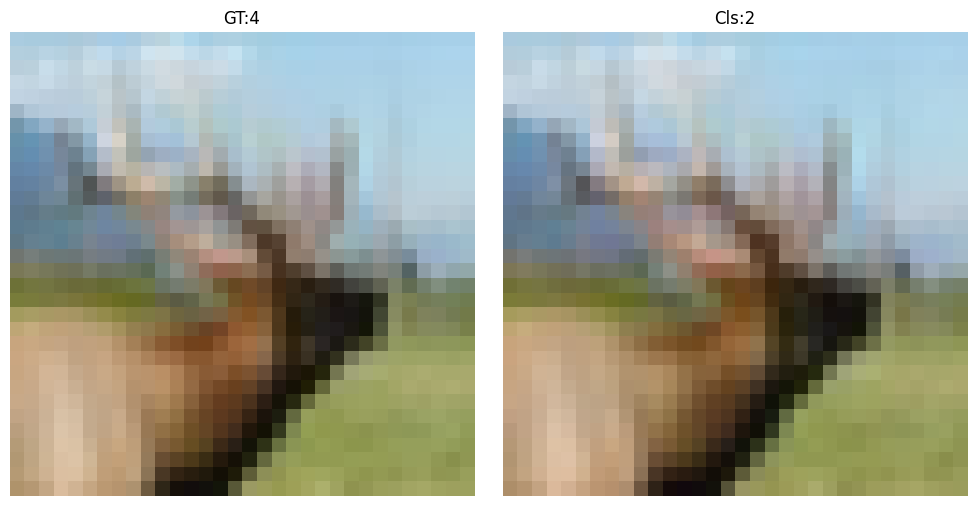

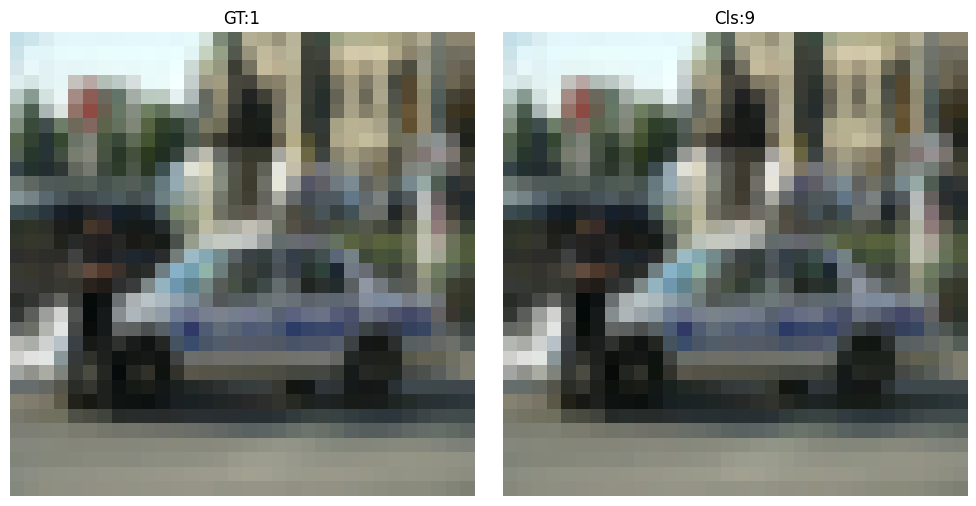

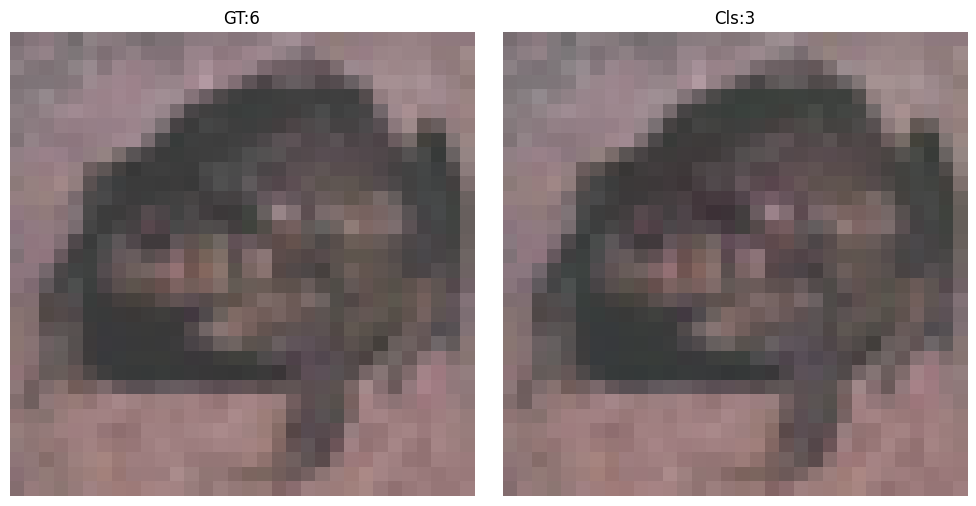

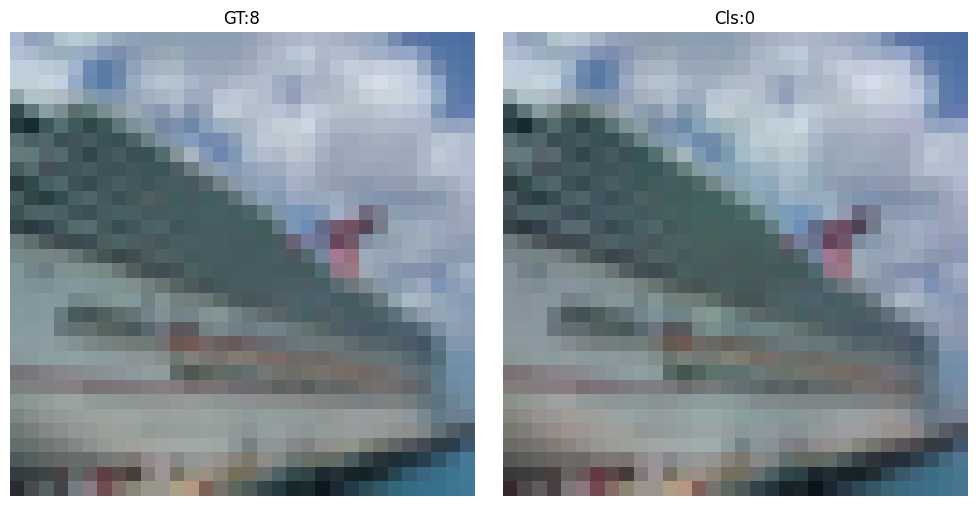

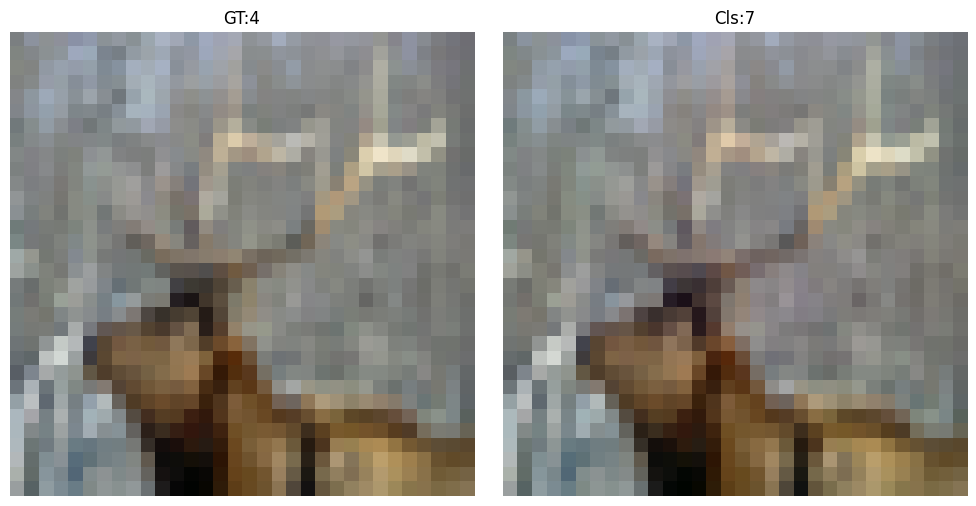

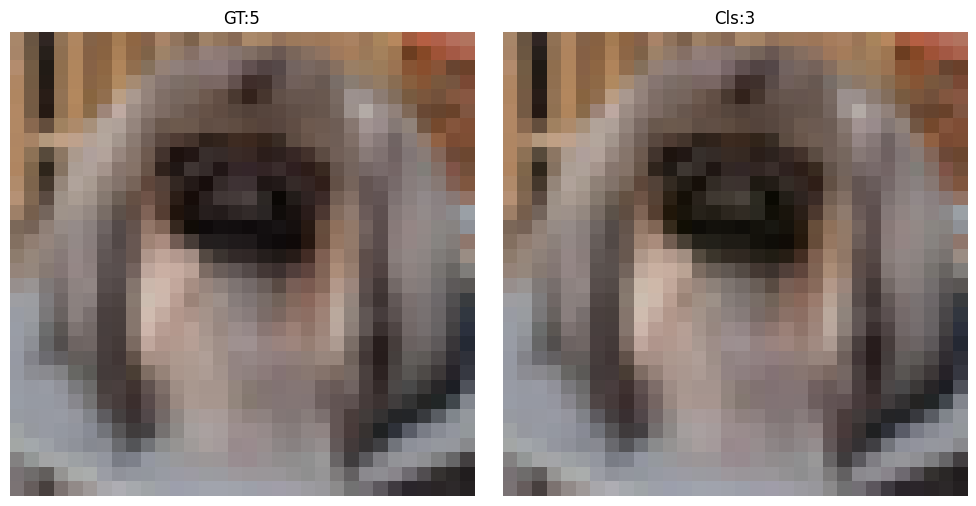

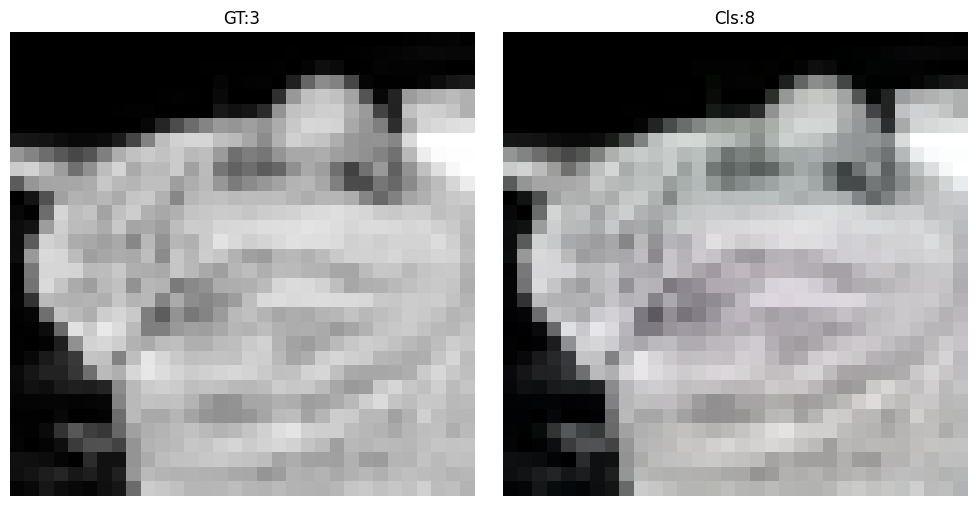

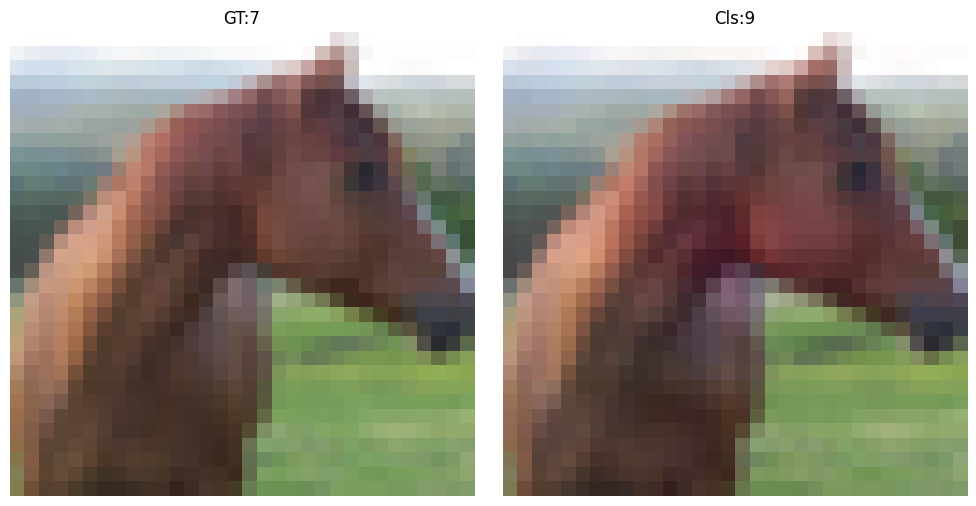

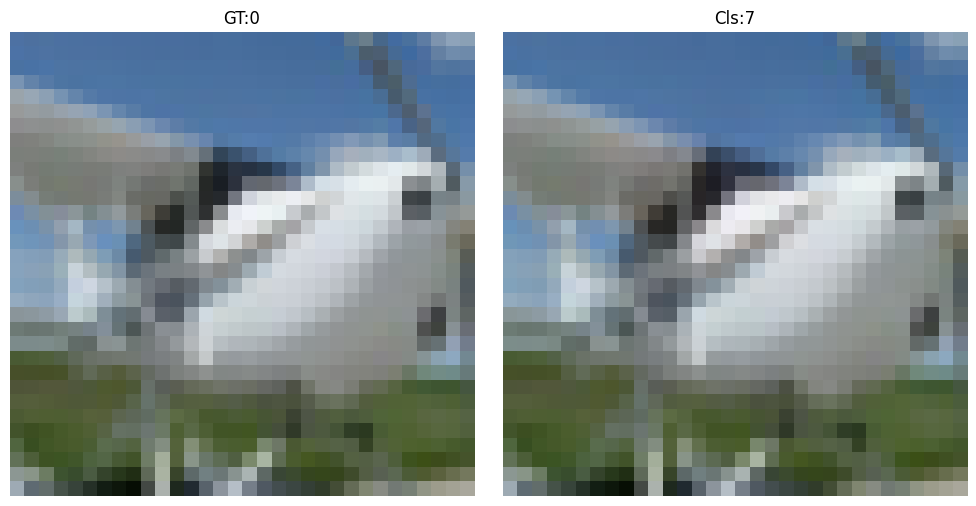

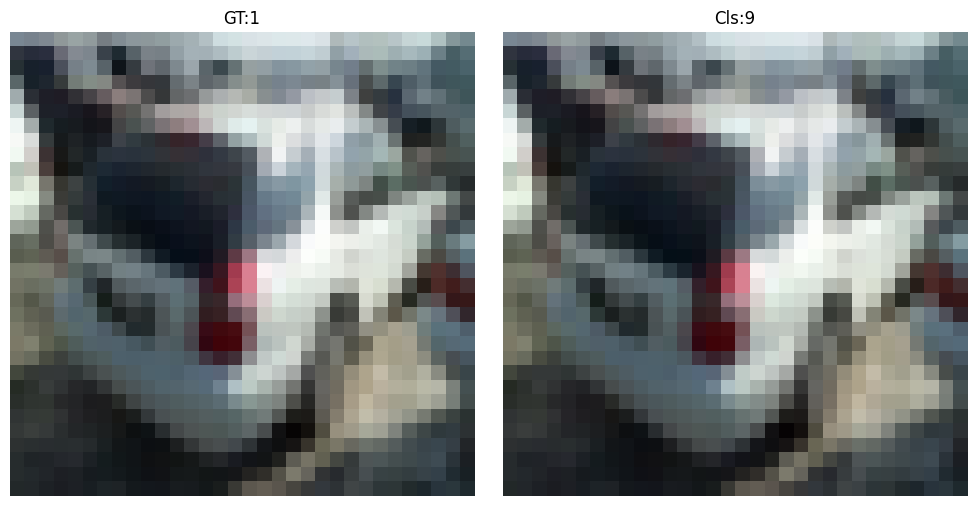

In [17]:
save_path = "/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f/MT_Baseline_a75d060c2415e722a953e03729658a14/Visualizations"

for idx in range(20):
    benign = images_benign[0][idx]
    cw_base = images_cw_base[0][idx]
    #cw_rbf = images_cw_rbf[0][idx]

    benign = benign.swapaxes(0,1)
    benign = benign.swapaxes(1,2)

    cw_base = cw_base.swapaxes(0,1)
    cw_base = cw_base.swapaxes(1,2)

    #cw_rbf = cw_rbf.swapaxes(0,1)
    #cw_rbf = cw_rbf.swapaxes(1,2)

    title_benign = f'GT:{true_labels_base[idx]}'
    title_base = f'Cls:{pred_labels_base[idx]}'
    #title_integrated = f'Cls:{pred_labels_integrated[idx]}, RBF:{pred_labels_integrated_rbf[idx]}'
    titles = [title_benign, title_base]
    plot_side_by_side(benign, cw_base,  idx, save_path, titles=titles)